# Estimation du prix d'un bien immobilier à Paris selon ses caractéristiques #

## Introduction ##

### Contexte du marché parisien ###

La trajectoire des prix immobiliers à Paris semblait inarrêtable. Après un doublement en dix ans, suivi d'une légère correction en 2015, le marché a atteint un sommet historique de 10 310 €/m² au premier trimestre 2023. Cette hausse s’explique notamment par des conditions de financement très favorables : entre 2015 et 2019, les taux d'intérêt moyens pour un crédit immobilier sur 20 ans étaient autour de 2,35 %, chutant à 1,25-1,5 % en 2020-2021 grâce aux politiques économiques liées à la COVID-19.
Cependant, cette dynamique s'est inversée en 2023. Les transactions ont chuté de 23 % au premier trimestre 2024 (en glissement annuel), et les prix ont reculé de 7,9 % en juin 2024, atteignant 9 190 €/m². Cette baisse est liée à la forte hausse des taux d’intérêt, passés de 1 % en 2021 à plus de 4 % fin 2023, et au durcissement des règles d’octroi des prêts, limitant le taux d’endettement à 35 % et la durée des emprunts à 25 ans. Ces facteurs ont réduit la demande immobilière, laissant le marché parisien à la traîne par rapport à d’autres métropoles européennes comme Madrid ou Lisbonne.
Dans ce contexte, de nombreux ménages s’interrogent : faut-il vendre maintenant ou attendre une reprise des prix ? Pour éclairer ces décisions, ce projet propose un modèle d’estimation des prix immobiliers à Paris. En analysant les principales caractéristiques influençant la valeur d’un bien, nous chercherons à mieux comprendre les dynamiques du marché et à fournir des outils d’aide à la décision.

### Installation des Packages ###

In [ ]:
pip install selenium webdriver-manager pandas numpy geopy dill matplotlib scipy seaborn folium scikit-learn xgboost s3fs

## I. Scraping ##

In [19]:
# A moins que vous ne souhaitiez scraper pendant 2 heures le site de bien ici, ne lancer pas ces lignes
# from scrapping import main
# main()

Cf fichier scraping dans le repo GitHub (où ce trouve notre code) 

## II. Prétraitement des données ##

In [20]:
#Importations
import re
import numpy as np
from collections import namedtuple
import pandas as pd

In [21]:
import s3fs
import pandas as pd
# On initialise le système S3 avec l'url fourni par le SSP cloud
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

# Définition du bucket du membre du groupe ayant les fichiers accessibles via son stockage s3 
bucket = "jhajjar"
chemin_s3 = f"{bucket}/Diffusion/listings.csv" #chemin du fichier csv issu du scraping, contenu dans le dossier Diffusion (en mode public)

# nom du fichier local qui sera créé 
fichier_local = "listings2.csv"

# téléchargement du fichier sur l'environnement local
try:
    fs.get(chemin_s3, fichier_local)
except Exception as e:
    print(f"erreur d'importation du fichier: {e}")

# création du dataframe, étiquetage des colonnes et suprression des annonces redondantes
df = pd.read_csv(fichier_local, names=["id", "type", "nb_pieces", "loc", "surface", "prix"], header=0).drop_duplicates()

df

,id,type,nb_pieces,loc,surface,prix
0,apimo-85473173,Appartement,1.0,75001 Paris 1er (Châtelet - Les Halles),29.0,364 000 €
1,hektor-Les-4-Quartiers-383,Appartement,1.0,75001 Paris 1er (Châtelet - Les Halles),23.0,301 000 €
2,hektor-PARISLUXURYHOMES-4007,Appartement,5.0,75002 Paris 2e (Palais Royal),106.0,2 490 000 €
3,ag754594-448898324,Studio,NaN,75001 Paris 1er (Saint-Germain - L'Auxerrois),27.0,365 000 €
5,keller-williams-1-34_1_53-180645,Appartement,2.0,75001 Paris 1er (Vendôme),67.0,1 190 000 €
...,...,...,...,...,...,...
19726,ag755800-412953689,Appartement,1.0,75020 Paris 20e (Père Lachaise - Réunion),35.0,239 600 €
19753,century-21-202_480_27885,Appartement,3.0,75020 Paris 20e (Plaine - Lagny),63.0,539 000 €
19758,netty-company34605jrw-appt-3212,Appartement,1.0,75020 Paris 20e (Gambetta),27.0,215 000 €
19767,demathieu-bard-immobilier-PR5E0076,GAMBETTA,NaN,75020 Paris 20e (Gambetta),NaN,435 000 à 1 350 000 €


In [22]:
#Modification des types
df['id'] = df['id'].astype(str)
df['type'] = df['type'].astype(str)
df['nb_pieces'] = pd.to_numeric(df['nb_pieces'], errors='coerce').astype('Int64')
df['loc'] = df['loc'].astype(str)
df['surface'] = pd.to_numeric(df['surface'], errors='coerce').astype('Int64')
df['prix'] =pd.to_numeric(df['prix'].str.replace(' ', '').str.replace('€', ''), errors='coerce').astype('Int64')

In [23]:
df.dtypes

id           object
type         object
nb_pieces     Int64
loc          object
surface       Int64
prix          Int64
dtype: object

In [24]:
#Gerer les NAN
#Gérer les nan du aux studios
df.loc[(df['type'] == 'Studio') & (pd.isnull(df['nb_pieces'])), 'nb_pieces'] = 1 # Si studio, 1 chambre
df

,id,type,nb_pieces,loc,surface,prix
0,apimo-85473173,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),29,364000
1,hektor-Les-4-Quartiers-383,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),23,301000
2,hektor-PARISLUXURYHOMES-4007,Appartement,5,75002 Paris 2e (Palais Royal),106,2490000
3,ag754594-448898324,Studio,1,75001 Paris 1er (Saint-Germain - L'Auxerrois),27,365000
5,keller-williams-1-34_1_53-180645,Appartement,2,75001 Paris 1er (Vendôme),67,1190000
...,...,...,...,...,...,...
19726,ag755800-412953689,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),35,239600
19753,century-21-202_480_27885,Appartement,3,75020 Paris 20e (Plaine - Lagny),63,539000
19758,netty-company34605jrw-appt-3212,Appartement,1,75020 Paris 20e (Gambetta),27,215000
19767,demathieu-bard-immobilier-PR5E0076,GAMBETTA,<NA>,75020 Paris 20e (Gambetta),<NA>,<NA>


In [25]:
#Supprimer les lignes restantes avec des NaN qui sont ,ici, des lignes avec soit nb_pieces, surface, prix None
df=df.dropna()

In [26]:
#Filtration pour ne pas avoir des types de batiments mals renseigné ou mal scrappé
df["count"] = df['type'].map(df['type'].value_counts()) #Enlever les types avec trop peu d'apparitions (qui sont des erreurs)
df=df[df["count"] > 10]
df=df.drop("count", axis=1)
df

/tmp/ipykernel_14803/3289413939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["count"] = df['type'].map(df['type'].value_counts()) #Enlever les types avec trop peu d'apparitions (qui sont des erreurs)


,id,type,nb_pieces,loc,surface,prix
0,apimo-85473173,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),29,364000
1,hektor-Les-4-Quartiers-383,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),23,301000
2,hektor-PARISLUXURYHOMES-4007,Appartement,5,75002 Paris 2e (Palais Royal),106,2490000
3,ag754594-448898324,Studio,1,75001 Paris 1er (Saint-Germain - L'Auxerrois),27,365000
5,keller-williams-1-34_1_53-180645,Appartement,2,75001 Paris 1er (Vendôme),67,1190000
...,...,...,...,...,...,...
19720,apimo-83966258,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),22,239000
19726,ag755800-412953689,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),35,239600
19753,century-21-202_480_27885,Appartement,3,75020 Paris 20e (Plaine - Lagny),63,539000
19758,netty-company34605jrw-appt-3212,Appartement,1,75020 Paris 20e (Gambetta),27,215000


A partir d'ici, nous avons fait un constat.
Les vendeurs choisissent l'intitulé de leur annonces, dont la localisation, cependant elles ne sont pas toujours normalisées, et parfois même totaltement éronnées. (Exemple 75003 Paris 3e (Châtelet - Les Halles))
Nous avons cond décidé de supposer ques les annonces étaient globalement de la forme (75020 Paris 20e (Gambetta)) mais que seule la partie entre parenthèse était bonne.
Ainsi notre but est de récupérer cette information, d'utiliser geopy pour avoir la "véritable adressse" et en plus la localisation.

In [27]:
# Uniformiser le format des localisation

#pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', 10)
df_ = df.copy()

# Extraire les informations entre parenthèses (quartiers) et les garder dans loc1
df_['loc1'] = df_['loc'].str.extract(r'\((.*?)\)')

# Extraire si il y a plusieures lieux (séparé par un -) le premier lieu dans loc2
df_['loc2'] = df_['loc1'].str.extract(r'^(.*?)\s-\s')
df_['loc2'] = df_['loc2'].fillna(df_['loc1'])

# Extraire les arrondissements (750XX) dans loc3 
df_['loc3'] = df_["loc"].str.extract(r'(750\d{2} [A-Za-z0-9 ]+ \d{1,2}[a-zA-Z]+)')

# Prioriser loc1 (quartiers) et, si absent, utiliser loc3 (arrondissements)
df_['loc1'] = df_['loc1'].fillna(df_['loc3'])

#S'il n'ay a aucune adresse
df_=df_.dropna(subset=['loc1', 'loc3'], how='all')


df_zones=df_[["loc1", "loc2", 'loc3']].drop_duplicates().copy()
df=df_.copy()

In [28]:
df

,id,type,nb_pieces,loc,surface,prix,loc1,loc2,loc3
0,apimo-85473173,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),29,364000,Châtelet - Les Halles,Châtelet,75001 Paris 1er
1,hektor-Les-4-Quartiers-383,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),23,301000,Châtelet - Les Halles,Châtelet,75001 Paris 1er
2,hektor-PARISLUXURYHOMES-4007,Appartement,5,75002 Paris 2e (Palais Royal),106,2490000,Palais Royal,Palais Royal,75002 Paris 2e
3,ag754594-448898324,Studio,1,75001 Paris 1er (Saint-Germain - L'Auxerrois),27,365000,Saint-Germain - L'Auxerrois,Saint-Germain,75001 Paris 1er
5,keller-williams-1-34_1_53-180645,Appartement,2,75001 Paris 1er (Vendôme),67,1190000,Vendôme,Vendôme,75001 Paris 1er
...,...,...,...,...,...,...,...,...,...
19720,apimo-83966258,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),22,239000,Père Lachaise - Réunion,Père Lachaise,75020 Paris 20e
19726,ag755800-412953689,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),35,239600,Père Lachaise - Réunion,Père Lachaise,75020 Paris 20e
19753,century-21-202_480_27885,Appartement,3,75020 Paris 20e (Plaine - Lagny),63,539000,Plaine - Lagny,Plaine,75020 Paris 20e
19758,netty-company34605jrw-appt-3212,Appartement,1,75020 Paris 20e (Gambetta),27,215000,Gambetta,Gambetta,75020 Paris 20e


Puisque les adresse ne sont pas toujours écrite de la meilleur des manières, il nous faut tester plusieures options (dans l'ordre loc1,loc2) dans geopy pour avoir une réponse.

In [29]:
from geopy.geocoders import Nominatim
from functools import partial
geolocator = Nominatim(user_agent="testing")
geocode = partial(geolocator.geocode, language="fr")
geocode_with_paris = lambda query: geolocator.geocode("%s, Paris FR" % query)

In [30]:
coordonnees_adresse={} #Dictionnaire liant un lieu à une coordonnée
dict_zone={} # dicttionnaire liant au mieux du possible le triplet loc1,lo2,lo3 à un triplet lotissement/rue, quartier, arrondissement

#D'abord les arrondissements
zone_arrondissement=df_zones[df_zones["loc1"]==df_zones["loc3"]]

for zone in zone_arrondissement.itertuples(index=False):
    try:
        location = geolocator.geocode(zone[0])
        print(location)
        arrondissement=location.address
        arrondissement_match=re.search(r"75\d+", arrondissement)
        arrondissement= arrondissement_match.group(0) if arrondissement_match else None
        
        
        coordonnees_adresse[arrondissement]=(location.address,location.latitude,location.longitude)
        dict_zone[zone]=(None,None,arrondissement)
    except:
        dict_zone[zone]=(None,None,None)


Paris 1er Arrondissement, Paris, Île-de-France, France métropolitaine, 75001, France


Paris 2e Arrondissement, Paris, Île-de-France, France métropolitaine, 75002, France
Paris 3e Arrondissement, Paris, Île-de-France, France métropolitaine, 75003, France
Paris 4e Arrondissement, Paris, Île-de-France, France métropolitaine, 75004, France
Paris 6e Arrondissement, Paris, Île-de-France, France métropolitaine, 75006, France
Paris 8e Arrondissement, Paris, Île-de-France, France métropolitaine, 75008, France
Paris 9e Arrondissement, Paris, Île-de-France, France métropolitaine, 75009, France
Paris 10e Arrondissement, Paris, Île-de-France, France métropolitaine, 75010, France
Paris 11e Arrondissement, Paris, Île-de-France, France métropolitaine, 75011, France
Paris 12e Arrondissement, Paris, Île-de-France, France métropolitaine, 75012, France
Paris 13e Arrondissement, Paris, Île-de-France, France métropolitaine, 75013, France
Paris 14e Arrondissement, Paris, Île-de-France, France métropolitaine, 75014, France
Paris 15e Arrondissement, Paris, Île-de-France, France métropolitaine, 

In [31]:
# L'arrondissement du 16e étant un peu spécial

# Declaring namedtuple()
Pandas = namedtuple('Pandas', ['loc1', 'loc2', 'loc3'])

#Ajout 75016
L = Pandas('75016 Paris 16e', np.nan, '75016 Paris 16e')
dict_zone[L]=(None,None,'75016')
coordonnees_adresse["75016"]=coordonnees_adresse["75116"]

#Modif 75116
L = Pandas('75116 Paris 16e', np.nan, '75116 Paris 16e')

dict_zone[L]=(None,None,'75116')



In [32]:
#Forme de dict_zone
next(iter(dict_zone.items())) #key: (lieu,quartier,arrondissement)

(Pandas(loc1='75001 Paris 1er', loc2=nan, loc3='75001 Paris 1er'),
 (None, None, '75001'))

In [33]:
#Forme de coordonnees_adresse
next(iter(coordonnees_adresse.items())) #key: (résultat requete geopy,coordonnées_x,coordonnées_y)

('75001',
 ('Paris 1er Arrondissement, Paris, Île-de-France, France métropolitaine, 75001, France',
  48.8646144,
  2.334396))

In [34]:
# #Sauvegarde intermédiaire
# coordonnees_adresse_1=coordonnees_adresse.copy() 
# dict_zone_1=dict_zone.copy()

In [35]:
#Pour le reste des adresses
zone_lieux=df_zones[df_zones["loc1"]!=df_zones["loc3"]]


# On devra chercher les quartier et arrondissement dans l'adresse donnée
quartier_pattern = r"Quartier\s[\w\s\'\-]+"
arrondissement_pattern = r"75\d+"

In [36]:
# # Ensure coordonnees_adresse and dict_zone are initialized properly
# coordonnees_adresse = coordonnees_adresse_1.copy()
# dict_zone = dict_zone_1.copy()

# Iterate through the sorted zone_lieux DataFrame
for zone in zone_lieux.sort_values(by="loc1").itertuples(index=False):
    try:
        location = None  # Initialize 
        adresse = None
        quartier_match = None
        arrondissement_match = None

        # Check if zone[0] is already in coordonnees_adresse
        if zone[0] in coordonnees_adresse:
            adresse = coordonnees_adresse[zone[0]][0]
            
        else:
            location = geocode_with_paris(zone[0])
            
            if location is not None:
                coordonnees_adresse[zone[0]] = (location.address, location.latitude, location.longitude)
                adresse = location.address

        # Use regex to extract quartier and arrondissement
        quartier_match = re.search(quartier_pattern, adresse)
        quartier = quartier_match.group(0) if quartier_match else None

        arrondissement_match = re.search(arrondissement_pattern, adresse)
        arrondissement = arrondissement_match.group(0) if arrondissement_match else None

        # Update dict_zone with the extracted information
        dict_zone[zone] = (zone[0], quartier, arrondissement)
        print((zone[0], quartier, arrondissement))

        # Check if we have the quartier and if it's not in coordonnees_adresse
        if quartier and quartier not in coordonnees_adresse:
            location_ = geocode_with_paris(quartier)
            if location_ is None:
                dict_zone[zone] = (zone[0], None, arrondissement)
            else:
                coordonnees_adresse[quartier] = (location_.address, location_.latitude, location_.longitude)

    except Exception as e:
        if "expected string or bytes-like object, got 'NoneType'" != str(e):
            #Erreur qui n'est pas adresse non trouvée
            print(f"Error processing zone {zone[0]}: {e}")
        # Handle fallback if zone[1] is the alternative name to process
        try:
            if zone[1] in coordonnees_adresse:
                adresse = coordonnees_adresse[zone[1]][0]
            else:
                location = geocode_with_paris(zone[1])

                if location is None:
                    dict_zone[zone] = (None, None, None)
                    print((None, None, None))
                    continue
                else:
                    coordonnees_adresse[zone[1]] = (location.address, location.latitude, location.longitude)
                    adresse = location.address

            # Extract quartier and arrondissement again
            quartier_match = re.search(quartier_pattern, adresse)
            quartier = quartier_match.group(0) if quartier_match else None

            arrondissement_match = re.search(arrondissement_pattern, adresse)
            arrondissement = arrondissement_match.group(0) if arrondissement_match else None

            # Update dict_zone with the information
            dict_zone[zone] = (zone[1], quartier, arrondissement)
            print((zone[1], quartier, arrondissement))

            # Check quartier geocoding if needed
            if quartier and quartier not in coordonnees_adresse:
                location_ = geocode_with_paris(quartier)
                if location_ is None:
                    dict_zone[zone] = (zone[1], None, arrondissement)
                else:
                    coordonnees_adresse[quartier] = (location_.address, location_.latitude, location_.longitude)

        except Exception as e:
            print(f"Error handling fallback zone {zone[1]}: {e}")


('Aligre', 'Quartier des Quinze-Vingts', '75012')
Error processing zone Aligre - Gare de Lyon: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Aligre+-+Gare+de+Lyon%2C+Paris+FR&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
('Aligre', 'Quartier des Quinze-Vingts', '75012')
Error processing zone Aligre - Gare de Lyon: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Aligre+-+Gare+de+Lyon%2C+Paris+FR&format=json&limit=1 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7faaacb755e0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))
('Aligre', 'Quartier des Quinze-Vingts', '75012')
Error processing zone Aligre - Gare de Lyon: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded w

In [37]:
#Quel tag n'a uniquement pas d'arrondissement (loc3)
{key: value for key, value in dict_zone.items() if  (value[2] is  None)}

{Pandas(loc1='75005 Paris 5e', loc2=nan, loc3='75005 Paris 5e'): (None,
  None,
  None),
 Pandas(loc1='Muette-Nord - Trocadéro', loc2='Muette-Nord', loc3='75016 Paris 16e'): (None,
  None,
  None),
 Pandas(loc1='Muette-Nord - Trocadéro', loc2='Muette-Nord', loc3=nan): (None,
  None,
  None)}

In [38]:
#Y a t'il bien une key dan le dictionnaire pour chaque zone
print(len(df_zones))
print(len(dict_zone)) 
#Normal car ajout de 75116

250
149


In [39]:
# #Save
# df_2=df.copy()
# df_zones_2=df_zones.copy()
# dict_zone_2=dict_zone.copy()
# coordonnees_adresse_2=coordonnees_adresse.copy()

In [40]:
# df=df_2.copy()
# df_zones=df_zones_2.copy()
# dict_zone=dict_zone_2.copy()
# coordonnees_adresse=coordonnees_adresse_2.copy()

# Iterate over the dictionary and supress the first value
#We do this cause we don't need the adress but just th coordinate in coordonnees_adresse
for key, value in coordonnees_adresse.items():
    if isinstance(value, tuple) and len(value) == 3:
        coordonnees_adresse[key] = value[1:] 

next(iter(coordonnees_adresse.items()))

('75001', (48.8646144, 2.334396))

In [41]:
LocationKey = namedtuple('Pandas', ['loc1', 'loc2', 'loc3'])

#Define a function to retrieve coordinates from the dictionary
def get_coordinates(row):
    try:
        # Ensure the row contains the correct columns
#       print((row['loc1'], row['loc2'], row['loc3']))
        loc1 = None if pd.isna(row['loc1']) else row['loc1']
        loc2 = None if pd.isna(row['loc2']) else row['loc2']
        loc3 = None if pd.isna(row['loc3']) else row['loc3']
        loc_key = LocationKey(loc1=loc1, loc2=loc2, loc3=loc3)
        
        # Return coordinates from dict_zone or (None, None, None) if not found
        return dict_zone.get(loc_key, (None, None, None))
    except KeyError as e:
        print(f"KeyError: {e}")
        return (None, None, None)

#Apply the function to each row of the DataFrame
df[['loc1', 'loc2', 'loc3']] = df.apply(get_coordinates, axis=1).apply(pd.Series)

# Resulting DataFrame
df

,id,type,nb_pieces,loc,surface,prix,loc1,loc2,loc3
0,apimo-85473173,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),29,364000,None,None,None
1,hektor-Les-4-Quartiers-383,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),23,301000,None,None,None
2,hektor-PARISLUXURYHOMES-4007,Appartement,5,75002 Paris 2e (Palais Royal),106,2490000,Palais Royal,Quartier du Palais Royal,75001
3,ag754594-448898324,Studio,1,75001 Paris 1er (Saint-Germain - L'Auxerrois),27,365000,Saint-Germain,None,75006
5,keller-williams-1-34_1_53-180645,Appartement,2,75001 Paris 1er (Vendôme),67,1190000,Vendôme,Quartier Vendôme,75001
...,...,...,...,...,...,...,...,...,...
19720,apimo-83966258,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),22,239000,Père Lachaise,Quartier du Père-Lachaise,75020
19726,ag755800-412953689,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),35,239600,Père Lachaise,Quartier du Père-Lachaise,75020
19753,century-21-202_480_27885,Appartement,3,75020 Paris 20e (Plaine - Lagny),63,539000,Plaine,Quartier de Charonne,75020
19758,netty-company34605jrw-appt-3212,Appartement,1,75020 Paris 20e (Gambetta),27,215000,None,None,None


In [42]:
#Define a function to retrieve coordinates from the dictionary
def get_coordinates_2(row, loc):
    try:
        # Ensure the row contains the correct columns
        locx= None if pd.isna(row[loc]) else row[loc]
        
        # Return coordinates from dict_zone or (None, None, None) if not found
        return coordonnees_adresse.get(locx, (None, None))
    except KeyError as e:
        print(f"KeyError: {e}") 
        return (None, None)

#Apply the function to each row of the DataFrame
df[['loc1_x', 'loc1_y']] = df.apply(lambda row: pd.Series(get_coordinates_2(row, "loc1")), axis=1)
df[['loc2_x', 'loc2_y']] = df.apply(lambda row: pd.Series(get_coordinates_2(row, "loc2")), axis=1)
df[['loc3_x', 'loc3_y']] = df.apply(lambda row: pd.Series(get_coordinates_2(row, "loc3")), axis=1)

# Resulting DataFrame 
df

,id,type,nb_pieces,loc,surface,prix,loc1,loc2,loc3,loc1_x,loc1_y,loc2_x,loc2_y,loc3_x,loc3_y
0,apimo-85473173,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),29,364000,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
1,hektor-Les-4-Quartiers-383,Appartement,1,75001 Paris 1er (Châtelet - Les Halles),23,301000,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
2,hektor-PARISLUXURYHOMES-4007,Appartement,5,75002 Paris 2e (Palais Royal),106,2490000,Palais Royal,Quartier du Palais Royal,75001,48.863585,2.336204,48.864603,2.336049,48.864614,2.334396
3,ag754594-448898324,Studio,1,75001 Paris 1er (Saint-Germain - L'Auxerrois),27,365000,Saint-Germain,None,75006,48.856553,2.333331,NaN,NaN,48.850433,2.332951
5,keller-williams-1-34_1_53-180645,Appartement,2,75001 Paris 1er (Vendôme),67,1190000,Vendôme,Quartier Vendôme,75001,48.866900,2.328549,48.866900,2.328549,48.864614,2.334396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19720,apimo-83966258,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),22,239000,Père Lachaise,Quartier du Père-Lachaise,75020,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929
19726,ag755800-412953689,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),35,239600,Père Lachaise,Quartier du Père-Lachaise,75020,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929
19753,century-21-202_480_27885,Appartement,3,75020 Paris 20e (Plaine - Lagny),63,539000,Plaine,Quartier de Charonne,75020,48.850152,2.402190,48.855145,2.397638,48.865042,2.398929
19758,netty-company34605jrw-appt-3212,Appartement,1,75020 Paris 20e (Gambetta),27,215000,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Supprimer les lignes sans arrondissement
df = df.dropna(subset

aa
print(len(df))

5539


In [44]:
#Save dictionnary in case of
import dill as pickle
with open("coordonnees_adresse.pkl", "wb") as file:
    pickle.dump(coordonnees_adresse, file)
with open("dict_zone.pkl", "wb") as file:
    pickle.dump(dict_zone, file)

ModuleNotFoundError: No module named 'dill'

## III. Statistiques descriptives & représentations graphiques - cartes ##

In [45]:
df_copie = df.copy()

In [82]:
df = df_copie
df

,id,type,nb_pieces,loc,surface,prix,loc1,loc2,loc3,loc1_x,loc1_y,loc2_x,loc2_y,loc3_x,loc3_y
2,hektor-PARISLUXURYHOMES-4007,Appartement,5,75002 Paris 2e (Palais Royal),106,2490000,Palais Royal,Quartier du Palais Royal,75001,48.863585,2.336204,48.864603,2.336049,48.864614,2.334396
3,ag754594-448898324,Studio,1,75001 Paris 1er (Saint-Germain - L'Auxerrois),27,365000,Saint-Germain,None,75006,48.856553,2.333331,NaN,NaN,48.850433,2.332951
5,keller-williams-1-34_1_53-180645,Appartement,2,75001 Paris 1er (Vendôme),67,1190000,Vendôme,Quartier Vendôme,75001,48.866900,2.328549,48.866900,2.328549,48.864614,2.334396
6,apimo-83606543,Maison,7,75006 Paris 6e (Saint-Germain - L'Auxerrois),341,15000000,Saint-Germain,None,75006,48.856553,2.333331,NaN,NaN,48.850433,2.332951
12,hektor-br-immobilier-4309,Appartement,2,75001 Paris 1er (Saint-Germain - L'Auxerrois),53,669000,Saint-Germain,None,75006,48.856553,2.333331,NaN,NaN,48.850433,2.332951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19656,hektor-arcales1-1270,Appartement,4,75020 Paris 20e (Plaine - Lagny),76,591000,Plaine,Quartier de Charonne,75020,48.850152,2.402190,48.855145,2.397638,48.865042,2.398929
19692,ag755800-420870928,Appartement,2,75020 Paris 20e (Père Lachaise - Réunion),10,99000,Père Lachaise,Quartier du Père-Lachaise,75020,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929
19720,apimo-83966258,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),22,239000,Père Lachaise,Quartier du Père-Lachaise,75020,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929
19726,ag755800-412953689,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),35,239600,Père Lachaise,Quartier du Père-Lachaise,75020,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929


Le dataframe issu du scraping comporte plus de 10 000 entrées et 15 variables.\
La variable "id" correspond à l'identifiant unique que le site donne à chaque annonce. Il est souvent composé du nom de l'agence immobilière et d'une suite de nombres.\
La variable "type" décrit le type du bien immobilier : appartement, maison, studio, loft/atelier/surface. Il n'y a pas tout les types issu du scraping, en effet, on impose une condition sur le nombre d'annonces par type dans le preprocessing comme vu précédemment.\
la variable "nb_pieces" correspond au nombre de pièces dans le logement. Par "pièces" on entend une pièce principal comme une chambre, un salon par exemple. (la cuisine / salle de bains / toilettes / couloirs / entrée n'étant pas comptés).\
La variable "loc1" indique la localisation du logement. Il ne s'agit pas d'une dénomination officielle mais de "sous-quartiers" arbitraires définis par un organisme nommé "Kelquartier" offrant des services d'informations aux plateformes immobilières. Certaines zones correspondent à des conseils de quartiers, d'autres à des quartiers administratifs mais une partie correspond à des zones informelles (désignations locales et historiques).\
Comme vu précédemment, "loc2" correspond au quartier de "loc1" et "loc3" correspond à l'arrondissement de "loc1" et "loc2". Pour chacune de ces variables de localisation on a grâce à geopy, des longitudes (x) et latitudes correspondantes (y)\
La variable "surface" est la superficie en mètre carré (loi Carrez) du logement.\
Finalement, la variable "prix" contient le prix en euros listé sur le site Bien'ici du bien immobilier en question. Il est important de noter que ce prix prend en compte les frais de notaire et d'agence.\

Dans un premier temps nous allons nous focaliser sur les données issues du scraping de bien'ici, puis, dans une seconde partie, nous allons exploiter les données géographiques enrichies par le preprocessing. Ainsi, pour le moment, nos analyses se concentreront sur les colonnes "id", "type", "nb_pièce", "prix", "surface", "loc1".

In [83]:
# définition des variables à étudier dans cette partie
colonnes_analyses = ["id", "type", "nb_pieces", "prix", "prix/m2","surface", "loc1"]

Nous créons une colonne prix du m2. En effet, à des fins de comparaison, analyser simplement le prix n'a pas vraiment de sens sans prendre en compte la surface du bien.

In [84]:
df["prix/m2"] = df["prix"] / df["surface"] #création de la colonne prix du m2

Afin de mieux appréhender notre dataframe, nous utilisons la fonction describe() de pandas. 

In [85]:
colonnes_descriptions = ["nb_pieces", "prix", "prix/m2", "surface"]
description_df = df[colonnes_descriptions].describe()
description_formattée = description_df.map(lambda x: f"{x:.2f}")  # écriture non scientifique et 2 chiffres après la virgule pour améliorer la clarté.
description_formattée

,nb_pieces,prix,prix/m2,surface
count,5539.00,5539.00,5539.00,5539.00
mean,2.78,743419.92,11008.32,64.17
std,1.55,829311.98,3713.96,47.41
min,1.00,22000.00,545.45,4.00
25%,2.00,319000.00,8888.89,31.00
50%,2.00,522500.00,10360.00,52.00
75%,4.00,849500.00,12278.15,83.00
max,17.00,15000000.00,52500.00,448.00


Avant d'interpréter les données, il est évident que plusieurs données résultent d'une anomalie/erreur de listing sur le site (ce ne sont pas des "outliers" mais des erreurs). Le prix minimum de 22 0000 € parait impossible pour les types de biens que nous avons retenu. Similairement, un prix du m2 de 545.54 n'est pas cohérent avec le marché parisien. Comme les valeurs maximales de nos variables paraissent possible (segment d'ultra luxe), nous nous concentrons sur les valeurs minimales afin de détecter une anomalie. Comme le prix du m2 prend en compte le prix et la surface nous commencons par cette variable. Nous supprimons la ligne associée à cette erreur. 

In [86]:
prix_moyen = df['prix/m2'].mean()
df2 = df.copy()
df2['écart à la moyenne'] = ((df['prix/m2'] - prix_moyen)/prix_moyen)*100
df2['écart à la moyenne'] = df2['écart à la moyenne'].map("{:.2f}%".format)
df2[colonnes_analyses+['écart à la moyenne']].nsmallest(20, 'prix/m2')

,id,type,nb_pieces,prix,prix/m2,surface,loc1,écart à la moyenne
3524,hektor-VINCENNES-5540,Maison,17,120000,545.454545,220,Olympiades,-95.05%
8595,ladresse-1-adresse-13734597,Appartement,1,22000,956.521739,23,Secrétan,-91.31%
15868,ag752451-450439421,Appartement,2,70000,1666.666667,42,Porte de Saint-Cloud,-84.86%
6291,ag752451-430946330,Appartement,3,151350,1991.447368,76,Porte de Saint-Cloud,-81.91%
9013,netty-ouhibi-appt-4781,Appartement,2,98500,2188.888889,45,La Villette,-80.12%
...,...,...,...,...,...,...,...,...
7437,ag752451-423849232,Appartement,3,193400,3223.333333,60,Porte de Clichy,-70.72%
3139,apimo-85046255,Appartement,3,230000,3239.43662,71,Vallée de Fecamp,-70.57%
6417,ag752451-422549092,Appartement,5,418772,3323.587302,126,Porte de Saint-Cloud,-69.81%
3263,ag752451-387489911,Appartement,2,190000,3333.333333,57,Aligre,-69.72%


On observe des prix du m2 extrêmement bas par rapport à la moyenne. En effet, sur le site, ces biens correspondent soit à des erreurs de listing, soit à des "nu propriété" soit à des ventes en "viager" (Le viager consiste en la vente d'un bien immobilier où le prix de vente est transformé en une rente viagère). Ainsi, le prix de ces biens n'est pas du tout déterminé de la même façon que ceux dont on cherche à estimer le prix. Le prix affiché n'est que le "bouquet" initial. Il nous faut alors déterminer un seuil plancher arbitraire du prix au m2 pour éviter de prendre en compte ces biens. Cependant, un prix plancher pour tous les biens paraît incohérent, en effet, un viager en plein centre pourrait coûter plus cher (au m2) qu'un appartement classique aux niveaux des portes de Paris. Ainsi on choisit arbitrairement un minimum du prix du m2 de 60% de la valeur moyenne du prix au m2 de la zone du bien en question.

In [87]:

prix_moyen_par_zone = df.groupby('loc1')['prix/m2'].mean().reset_index() # on définit la moyenne du prix du m2 par zone
prix_moyen_par_zone.rename(columns={'prix/m2': 'moyenne_prix_m2_par_loc1'}, inplace=True) # afin de faciliter le merge qui arrive

df = df.merge(prix_moyen_par_zone, on='loc1', how='left') # on merge sur le dataframe initial pour avoir, pour chaque bien, la moyenne du prix du m2 de sa zone

ratio_seuil = 0.6 # on choisit arbitrairement 60%

df['seuil_prix_m2'] = ratio_seuil * df['moyenne_prix_m2_par_loc1'] # on calcule pour chaque bien (chaque zone) la valeur minimale du prix du m2 autorisée

print(f"Nombre d'annonces avec 'prix/m2' au moins {(1 - ratio_seuil)*100}% inférieur à la moyenne de leur loc1 : {df[df['prix/m2'] <= df['seuil_prix_m2']].shape[0]}")

df = df[df['prix/m2'] > df['seuil_prix_m2']] # on conserve les biens qui ont un prix du m2 suffisant comparativement à leur zone

df.drop(['moyenne_prix_m2_par_loc1', 'seuil_prix_m2'], axis=1, inplace=True) # on supprime les colonnes temporaires pour améliorer la visibilité



Nombre d'annonces avec 'prix/m2' au moins 40.0% inférieur à la moyenne de leur loc1 : 101


Reprenons maintenant l'analyse descriptive de notre dataframe :

In [88]:
def description_listings(df : pd.DataFrame): # création d'une fonction qui sera re-utilisée plus tard
    description_listings = df[colonnes_descriptions].describe()
    description_écrite = description_listings.map(lambda x: f"{x:.0f}")  # écriture non scientifique et arrondie à l'unité pour améliorer la clarté.
    description_formattée = description_listings.map(lambda x: f"{x:.2f}") # écriture non scientifique et 2 chiffres après la virgule pour améliorer la clarté.
    print(f"Le logement médian à Paris fait {description_écrite.loc['50%','surface']} m2, comporte {description_écrite.loc['50%','nb_pieces']} pièces et coûte {description_écrite.loc['50%','prix']}€ soit {description_écrite.loc['50%','prix/m2']}€ du m2 (avec frais d'agence et notarial)")
    return description_formattée
description_listings(df)

Le logement médian à Paris fait 52 m2, comporte 2 pièces et coûte 525500€ soit 10427€ du m2 (avec frais d'agence et notarial)


,nb_pieces,prix,prix/m2,surface
count,5438.00,5438.00,5438.00,5438.00
mean,2.77,750080.58,11111.42,64.00
std,1.54,834276.28,3655.75,47.26
min,1.00,52000.00,5000.00,4.00
25%,2.00,320000.00,8969.78,31.00
50%,2.00,525500.00,10427.05,52.00
75%,4.00,850000.00,12313.27,83.00
max,17.00,15000000.00,52500.00,448.00


Nous avons un peu moins de 10 000 observations, une taille convenable pour pouvoir étudier les comportements statistiques asymptotiques et disposer d'une certaine représentativité du marché immobilier parisien.

La surface moyenne (64.71 m2) et médiane (52 m2) sont significativement éloignées. L'écart indique une distribution asymétrique vers la droite, quelques biens tirant la moyenne à la hausse. En effet un plancher minimal s'applique pour un bien immobilier (le minimum étant ici de 4 m2) tandis que le plafond peut être bien plus élevé (ici quasiment 448 m2 au maximum). D'un côte les studettes/locaux sont nombreux mais de l'autre les grands appartements haussmanniens et l'immobilier de luxe compensent largement.

Le nombre de pièces médian (2) est inférieur au nombre de pièces moyen (2.78), ainsi, la distribution est asymétrique vers la droite. Le raisonnement est similaire avec celui de la surface, le minimum est naturellement de 1 tandis que le maximum monte à 17 pièces (lié au luxe). Un immeuble représentatif parisien dispose (intuitivement) d'une chambre et d'un salon.

Le même raisonnement peut être appliqué pour le prix où l'on observe un écart de quasiment 220 000 euros entre la moyenne et la médiane ce qui indique que la distribution est fortement asymétrique vers la droite. On observe un écart type encore plus élevé que la moyenne qui dévoile une variabilité très importante dans les données. le prix du m2 (prix/surface) étant une fonction du prix, hérite de cette distribution asymétrique bien que dans une plus faible mesure.

Nous avons donc des distributions asymétriques à droite caractéristiques du marché immobilier parisien qui propose une forte diversité de biens dans un espace réduit et très attractif (centre économique, politique, culture et international). Le segment d'ultra luxe est particulièrement important. On pourrait intuitivement retrouver des distributions similaires dans d'autres centres économiques européens comme Londres, Munich ou Genève.

 Afin de diminuer l'importance des valeurs extrêmes nous utilisons une transformation logarithmique pour le prix.

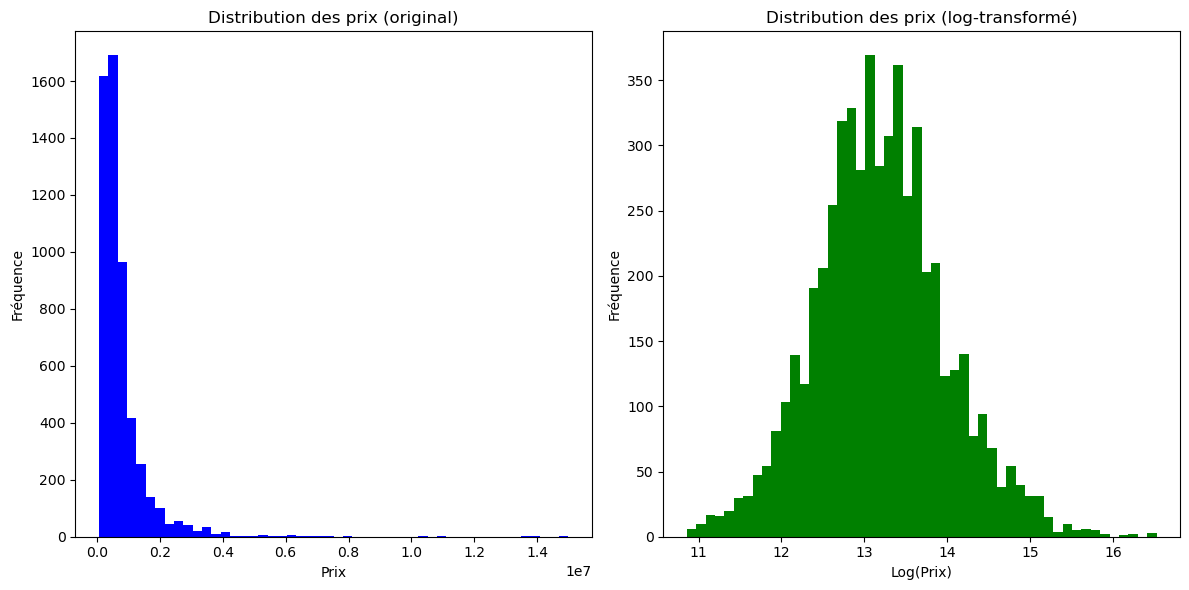

In [89]:
import matplotlib.pyplot as plt
import numpy as np
df['log(prix)'] = np.log(df['prix']) # transformation logarithmique grâce au np.log de numpy

def graph_distribution_prix(df: pd.DataFrame): # fonction que l'on réutilisera
    plt.figure(figsize=(12, 6)) # taille convenable
    
    # Histogramme avant transformation
    plt.subplot(1, 2, 1) # position à gauche dans le subplot
    plt.hist(df['prix'], bins=50, color='blue') # histogramme avec 50 échantillons 
    plt.title('Distribution des prix (original)')
    plt.xlabel('Prix')
    plt.ylabel('Fréquence')
    
    # Histogramme après transformation
    plt.subplot(1, 2, 2) # position à droite dans le subplot
    plt.hist(df['log(prix)'], bins=50, color='green') # histogramme avec 50 échantillons
    plt.title('Distribution des prix (log-transformé)')
    plt.xlabel('Log(Prix)')
    plt.ylabel('Fréquence')
    
    plt.tight_layout()
    plt.show()



graph_distribution_prix(df)

La log normalisation nous permet de passer d'une distribution fortement asymétrique à une distribution proche d'une gaussienne ce qui sera utile pour la modélisation. De plus, la log-transformation permet une analyse graphique plus simple car elle réduit la dispersion.

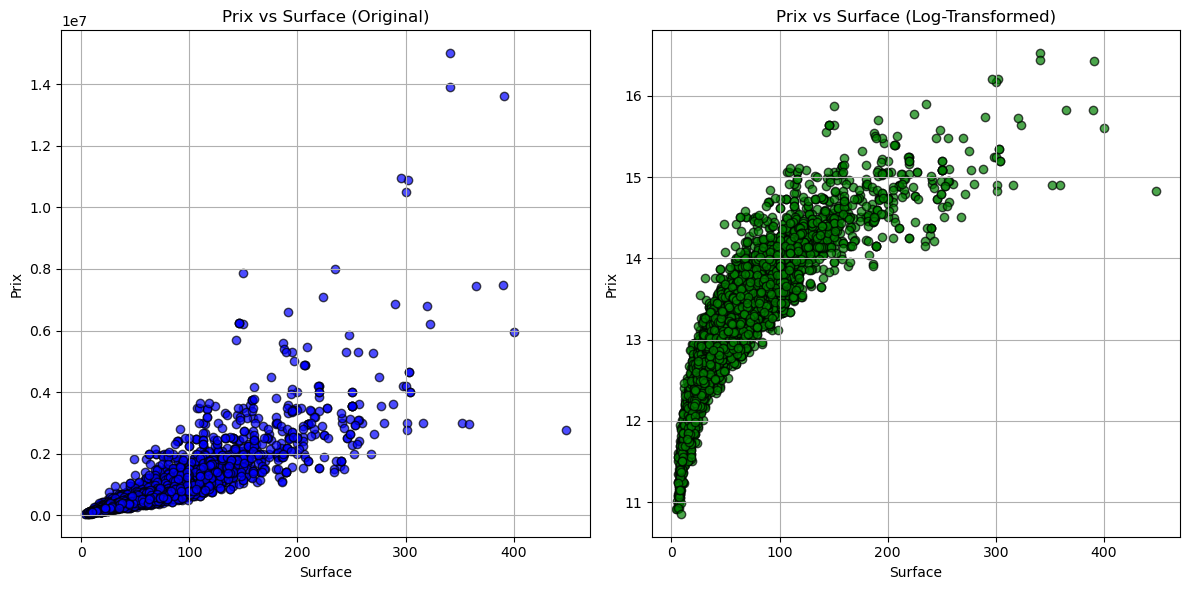

In [90]:
def graph_prix_vs_surface(df: pd.DataFrame):
    plt.figure(figsize=(12, 6)) 
    
    plt.subplot(1, 2, 1)
    plt.scatter(df['surface'], df['prix'], alpha=0.7, color='blue', edgecolor='k')
    plt.title('Prix vs Surface (Original)')
    plt.xlabel('Surface')
    plt.ylabel('Prix')
    plt.grid(True)
    

    plt.subplot(1, 2, 2)
    plt.scatter(df['surface'], df['log(prix)'], alpha=0.7, color='green', edgecolor='k')
    plt.title('Prix vs Surface (Log-Transformed)')
    plt.xlabel('Surface')
    plt.ylabel('Prix')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

graph_prix_vs_surface(df)

Procédons maintenant à l'analyse descriptive graphique de nos différentes variables.
Pour la variable surface, examinons la distribution du type de bien immobilier.

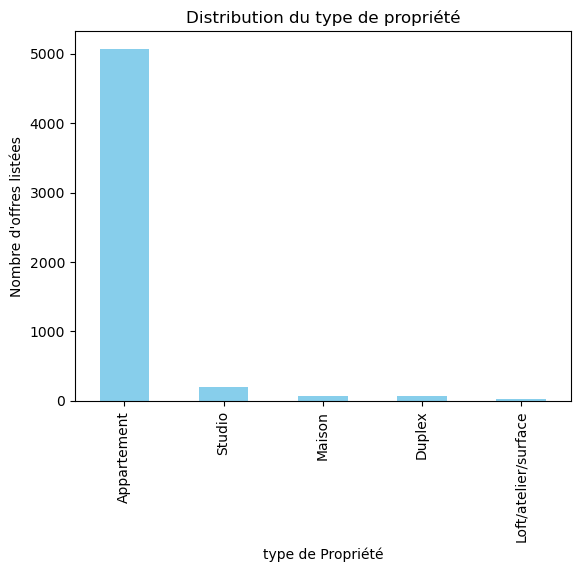

In [91]:
def graph_distribution_type(df: pd.DataFrame): # fonction que l'on réutilisera

    nombre_de_types = df['type'].value_counts() # compte le nombre de biens pour chaque "types" existants
    nombre_de_types.plot(kind='bar', color='skyblue') # crée un diagramme en barres
    plt.title('Distribution du type de propriété')
    plt.xlabel('type de Propriété')
    plt.ylabel("Nombre d'offres listées")
    plt.show()

graph_distribution_type(df)


Sans surprises, la grande majorité des biens offerts sont des appartements, héritages des travaux dirigés par le Baron Haussmann entre 1853 et 1870.  
Cependant les annonces étant remplies par des agences, elles sont sujettes à erreur, surtout pour la catégorisation des biens. Par exemple, pour les petites surfaces, on trouve un certain nombre de studios qui sont catégorisés en tant qu'appartements et inversement. La dénomination choisie de "studio" ne respecte souvent pas la réglementation française (une surface habitable minimale de 9m, une hauteur sous plafond d'au moins 2,20 mètres, un volume habitable d'au moins 20 m3).

Pour les autres types (hors Loft/atelier/surface), intuitivement, ils devraient ajouter de la valeur aux biens. En effet, posséder une maison à Paris raisonne avec exclusivité, de même pour un duplex. Testons cette intuition avec un test t de Student.

In [92]:
from scipy.stats import ttest_ind


prix_maisons = df[df['type'] == 'Maison']['log(prix)'] # log du prix des maisons
prix_duplex = df[df['type'] == 'Duplex']['log(prix)'] # log du prix des duplex
prix_appartements = df[df['type'] == 'Appartement']['log(prix)'] # log du prix des appartements
# on effectue 2 tests t de student en considérant les échantillons comme indépendants et les variance des prix comme étant différentes. 
stat, p_value = ttest_ind(prix_maisons, prix_appartements, equal_var=False) # H0 : la moyenne des prix des appartements et des maisons est égale, H1 : elles sont différentes
stat2, p_value2 = ttest_ind(prix_duplex, prix_appartements, equal_var=False) # H0 : la moyenne des prix des appartements et des duplex est égale, H1 : elles sont différentes

print(f"Pour les Maisons : T-statistic: {stat}, P-value: {p_value}")
print(f"Pour les Duplex : T-statistic: {stat2}, P-value: {p_value2}")



Pour les Maisons : T-statistic: 15.519961825148787, P-value: 2.1744697544118086e-24
Pour les Duplex : T-statistic: 6.692253939139182, P-value: 4.931969713166535e-09


On observe des p.values inférieures à 1%, il y a bien une différence de prix significative entre les appartements d'un côté et les maisons et duplex de l'autre. En prenant en compte la surface des biens on observe que les moyennes sont très proches, et même, que celle des maisons est plus faible. Cela s'explique par le fait qu'un duplex ou une maison nécessite une surface plus grande ce qui, par mètre carré, compense le prix élevé.

In [93]:
prix_par_type = df.groupby('type')['prix/m2'].agg(['mean','median','count'])
prix_par_type


,mean,median,count
type,,,
Appartement,11087.319211,10393.939394,5073
Duplex,11729.658758,11192.307692,67
Loft/atelier/surface,10181.318242,10368.112014,30
Maison,13100.04536,11526.315789,69
Studio,10968.35248,10787.878788,199


En prenant en compte la surface des biens on observe que les moyennes sont très proches, et même, que celle des maisons est plus faible. Cela s'explique par le fait qu'un duplex ou une maison nécessite une surface plus grande ce qui, par mètre carré, compense le prix élevé.

La question se pose maintenant sur la catégorie Loft/atelier/surface. la moyenne du prix du m2 est de 9438€ soit près de 15% plus faible que la moyenne globale des biens immobiliers. En effet, un loft désigne communément un logement aux espaces ouverts issu d'un ancien atelier/entrepôt. Ces logements sont souvent moins chers au m2 car ils sont souvent destinés à faire office de bureaux de professions libérales ou bien de locaux commerciaux. Bien qu'une partie d'entre eux peuvent être considérés comme appartenant à la catégorie "appartement", nous ne pouvons pas filtrés plus précisément ces biens. Nous décidons ainsi de les supprimer en raison de leur faible nombre.

In [94]:
df = df[df['type'] != "Loft/atelier/surface"]

Intéressons-nous maintenant aux corrélations entre nos différentes variables. On utilise la fonction corr() couplée à la librairie "seaborn" pour les visualiser.

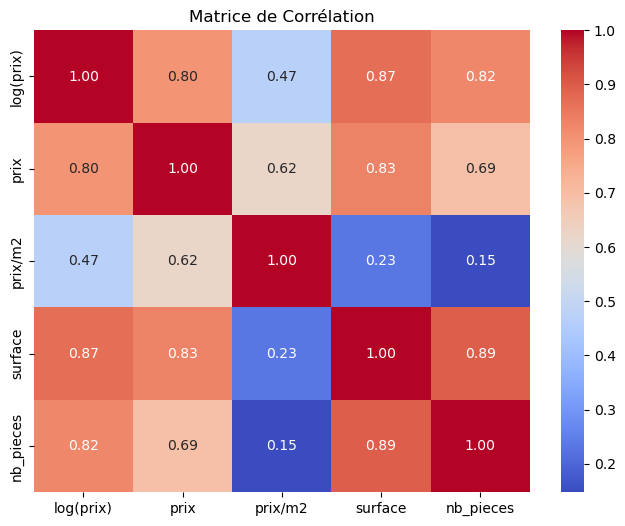

In [95]:
import seaborn as sns


colonnes_numériques = ['log(prix)', 'prix', 'prix/m2', 'surface', 'nb_pieces'] # la corrélation n'a de sens que pour des variables numériques

def graph_correlation_heatmap(df: pd.DataFrame, numerical_cols: list):

    listings_numerique = df[numerical_cols] # dataframe avec nos colonnes numériques
    matrice_corr = listings_numerique.corr() # création de la matrice de corrélation
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrice_corr, annot=True, fmt=".2f", cmap="coolwarm") # heatmap avec les coefficients de corrélation affichés avec deux chiffres après la virgule
    plt.title("Matrice de Corrélation")
    plt.show()

graph_correlation_heatmap(df, colonnes_numériques)


Naturellement, le prix (et le log(prix)) est corrélé positivement avec la surface du bien et son nombre de pièces. En effet, pour le prix on observe une correlation forte, respectivement de 0.85 et 0.72. Intuitivement, si un bien est plus grand ou dispose de plus de pièces, il sera, toute chose égale par ailleurs, plus cher. Cependant, on observe que pour le prix du m2 les corrélations restent positives mais deviennent faibles (0.20 et 0.13 respectivement). Le fait que le prix du m2 soit corrélé positivement avec la surface suggère que l'augmentation du prix du bien surpasse l'augmentation de la surface. Ce phénomène peut paraître contre-intuitif pour certaines surfaces. Pour clarifier, nous analysons le coefficient de Pearson entre le prix du m2 et la surface selon les quantiles de la surface.

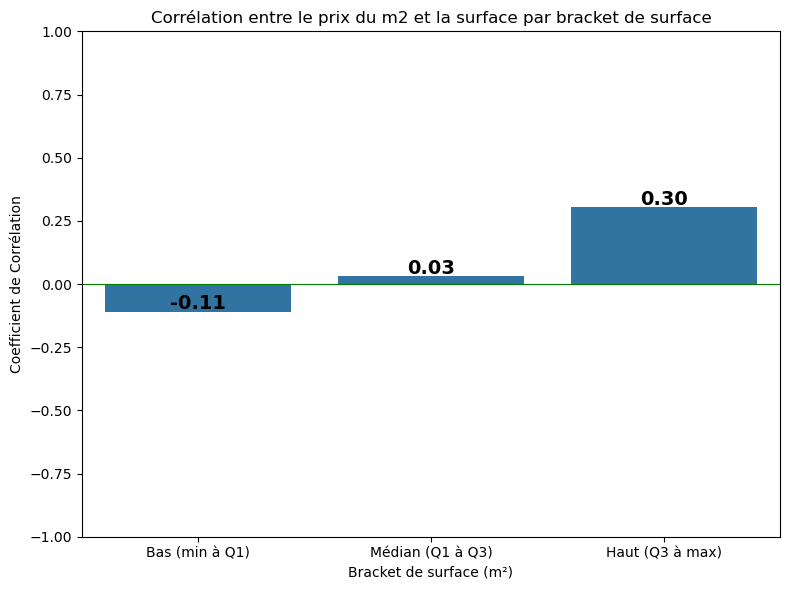

In [96]:

def graph_bar_correlation_bracket(df: pd.DataFrame):

    Q1 = df['surface'].quantile(0.25)
    Q2 = df['surface'].quantile(0.50)
    Q3 = df['surface'].quantile(0.75)
    
    # Définition des brackets

    # on définit des échantillons (des "brackets"), ici on catégorise les biens de façon arbitraire selon les quantiles de surface
    bins = [df['surface'].min(), Q1, Q3, df['surface'].max()] 
    labels = ['Bas (min à Q1)', 'Médian (Q1 à Q3)', 'Haut (Q3 à max)'] 

    # Crée une nouvelle colonne 'surface_bracket' en classant les valeurs de la surface selon les intervalles prédéfinis
    df['surface_bracket'] = pd.cut(df['surface'], bins=bins, labels=labels, include_lowest=True) 



    # Calcul des corrélations par bracket
    correlation_dict = {}
    for bracket in labels: # loop sur chaque intervalle prédéfini
        subset = df[df['surface_bracket'] == bracket] # dataframe contenant que les logements appartenant à l'intervalle de l'itération
        corr = subset['prix/m2'].corr(subset['surface'], method='pearson') # coefficient de corrélation de Pearson entre le prix du m2 et la surface
        correlation_dict[bracket] = corr
    
  
    # crée un dataframe à partir du dictionnaire de corrélation
    corr_listings = pd.DataFrame.from_dict(correlation_dict, orient='index', columns=['Corrélation']).reset_index().rename(columns={'index': 'Bracket de surface'}) 
    corr_listings = corr_listings.sort_values('Bracket de surface') # tri croissant pour le graphique
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Bracket de surface', y='Corrélation', data=corr_listings, order=labels) # graphique de barres dans l'ordre prédéfini
    
    for index, row in corr_listings.iterrows():
        # affichage des coefficients sur chaque barre
        plt.text(index, row.Corrélation+0.01, f"{row.Corrélation:.2f}", ha='center', fontsize = 14, fontweight ='bold')
    
    plt.title('Corrélation entre le prix du m2 et la surface par bracket de surface')
    plt.ylim(-1, 1) # la corrélation est à valeurs dans [-1,1]
    plt.ylabel('Coefficient de Corrélation')
    plt.xlabel('Bracket de surface (m²)')
    plt.axhline(0, color='green', linewidth=0.8) # ligne : coefficient de corrélation = 0 
    plt.tight_layout()
    plt.show()

graph_bar_correlation_bracket(df)

Ce résultat souligne la diversité des segments du marché parisien. Une interprétation possible est que les grandes surfaces étant souvent destinés à des familles dont le budget est plus élevé (ou des investisseurs), ceux-ci valorisent d'avantage la qualité du bien que son prix du m2, ainsi, une augmentation de la surface peut justifier un prix plus élevé du m2. La demande est moins élastique et la rareté accentue le prix/m² à mesure que la surface augmente.\
Pour les plus petits logements, le prix du m2 est initialement élevé car ils sont souvent des biens d'investissements (studio/appartement étudiant/Airbnb). De ce fait, ajouter quelques mètres carrés dans cette gamme ne rehausse pas forcément la valeur au m² si l’appartement reste, par exemple, un T1 plutôt qu’un T2. En d’autres termes, une studette de 15 m² à 18 m² ne modifie pas drastiquement l’attrait du bien pour les investisseurs. Le loyer potentiel n’augmentant pas proportionnellement.\
Pour les biens "médians", souvent recherchés par la "classe moyenne", la surface reste importante mais d'autres facteurs pèsent autant que le prix au m2. On peut citer l'étage, la localisation ou la luminosité.

Afin de préparer la modélisation du prix du m2 d'un logement parisien, il nous est nécessaire d'identifier les "outliers" qui pourrait nous poser des problèmes. On utilise une approche graphique.

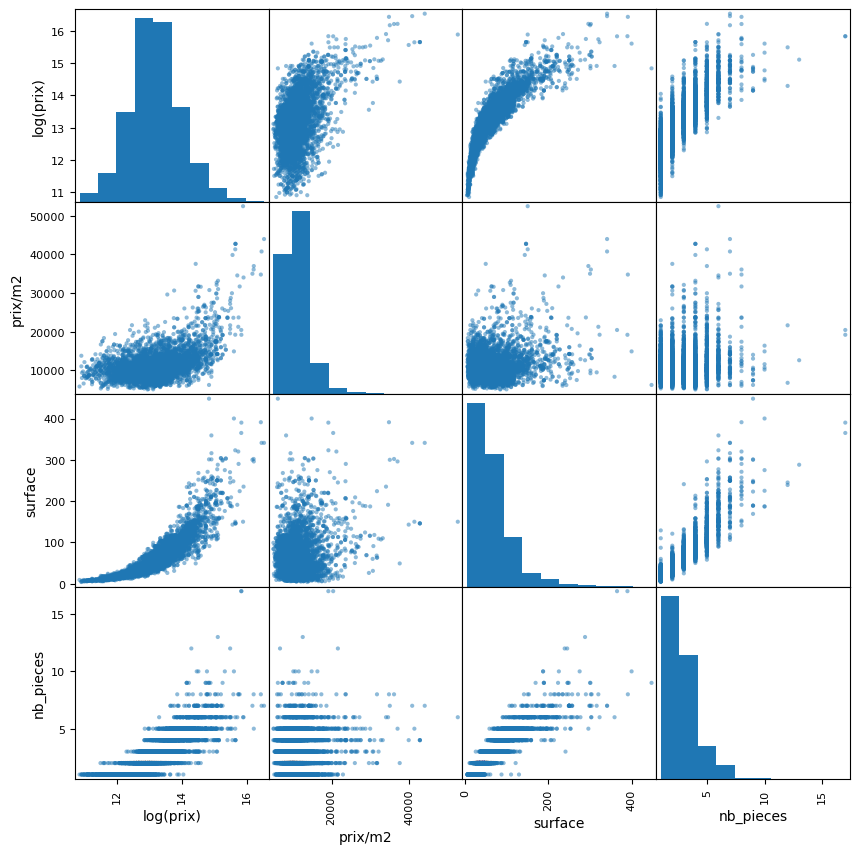

In [97]:
colonnes_graphiques = ["log(prix)", "prix/m2", "surface", "nb_pieces"]
def graph_matrice_scatter(df: pd.DataFrame, numerical_cols: list):
    # Génère une matrice de graphiques de dispersion (scatter plots) pour toutes nos variables numériques qu'on souhaite plot
    pd.plotting.scatter_matrix(df[colonnes_graphiques], figsize=(10, 10))  
    plt.show()

graph_matrice_scatter(df,colonnes_numériques)

Sur ce graphique on retrouve les différentes conclusions précédemment présentées. Nous voyons en diagonale les distributions plus ou moins asymétriques. De plus on retrouve à la première et deuxième lignes les corrélations positives du prix ou log(prix) aux pièces et surface et les corrélations plus flous du prix du m2 à la troisème ligne.
Ce graphique nous permet d'identifier les points extrêmes ("outliers") et de juger de la pertinence de les conserver dans le cadre de notre modélisation.

Premier outlier : un logement avec un prix du m2 très élevé pour son nombre de pièces et sa surface.

In [98]:
df[colonnes_analyses].loc[df["prix/m2"] > 50000] # garde le(s) propriété(s) avec un prix du m2 supérieur à 50 000€

,id,type,nb_pieces,prix,prix/m2,surface,loc1
675,apimo-7012481,Appartement,6,7875000,52500.0,150,Triangle d'Or


Il s'agit donc d'un appartement à 52500€ le m2 ce qui est près de 5 fois plus que la moyenne. Cependant, cela pourrait en partie s'expliquer par le sous-quartier exclusif du "Triangle d'Or", terme caractérisant une zone géographique prestigieuse et haut de gamme dans plusieurs villes françaises. Entres autres, à Paris, le Triangle d'Or est délimité par les avenues Montaigne, des Champs-Élysées et George-V. Comparons alors ce prix pharamineux aux autres logements offerts dans le Triangle d'Or.

In [99]:
df.groupby('loc1')['prix/m2'].mean()["Triangle d'Or"]

np.float64(22422.484155707294)

La propriété a un prix par m2 deux fois plus élevé que la moyenne du quartier qui est elle même déjà exceptionnellement haute. afin de négliger l'effet inflationniste et non représentatif de ce bien sur notre modèle, nous décidons de supprimer cette offre.   

In [100]:
df = df.drop(index = df['prix/m2'].idxmax())

Nous avons très peu de données pour les logements d'ultra luxe comportant au moins 13 pièces. De plus sur ce segment, les prix varient substantiellement car les appartements comportent des caractéristiques très exclusives qui justifient (pour certains) leur prix. Notre scraping ne nous permet cependant pas de quantifier ces caractéristiques spécifiques. Ainsi nous décidons de supprimer ces offres non représentatives.

In [101]:
print(f"on supprime {df[df['nb_pieces'] >= 9].shape[0]} annonces")
df = df[df['nb_pieces'] < 9]

on supprime 21 annonces


In [102]:
description_listings(df)

Le logement médian à Paris fait 51 m2, comporte 2 pièces et coûte 525000€ soit 10427€ du m2 (avec frais d'agence et notarial)


,nb_pieces,prix,prix/m2,surface
count,5386.00,5386.00,5386.00,5386.00
mean,2.74,736000.05,11106.09,62.83
std,1.46,806328.64,3613.41,44.85
min,1.00,52000.00,5000.00,4.00
25%,2.00,320000.00,8977.27,31.00
50%,2.00,525000.00,10427.05,51.00
75%,4.00,849000.00,12313.27,82.00
max,8.00,15000000.00,43988.27,391.00


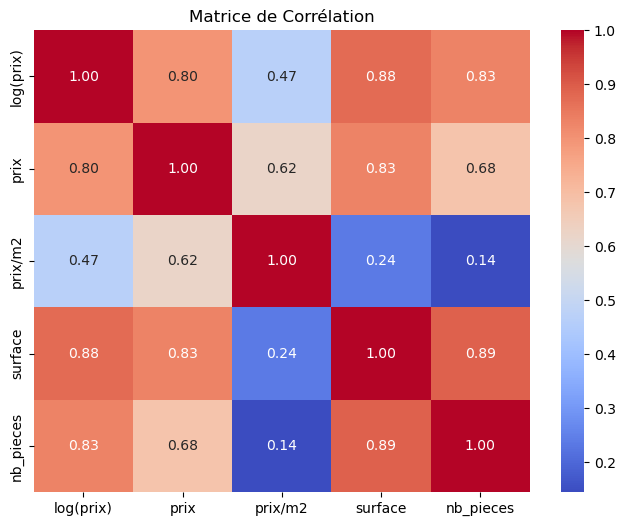

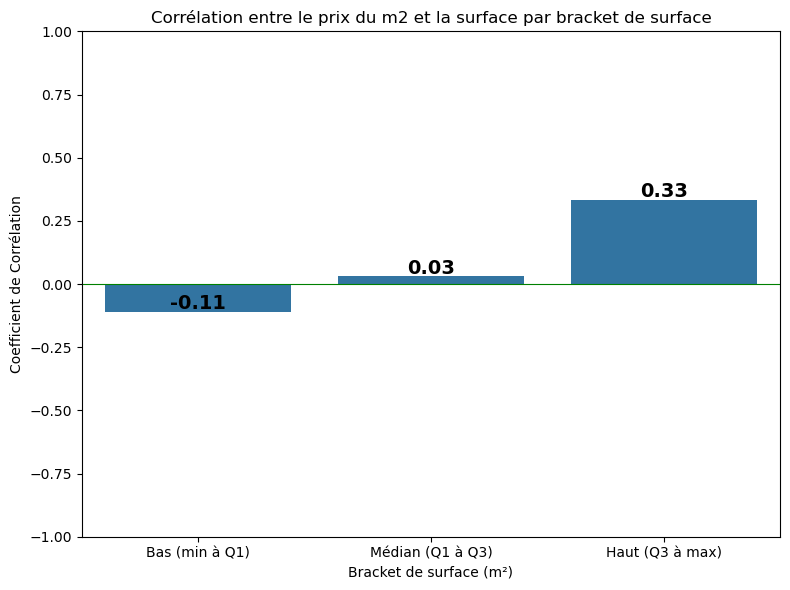

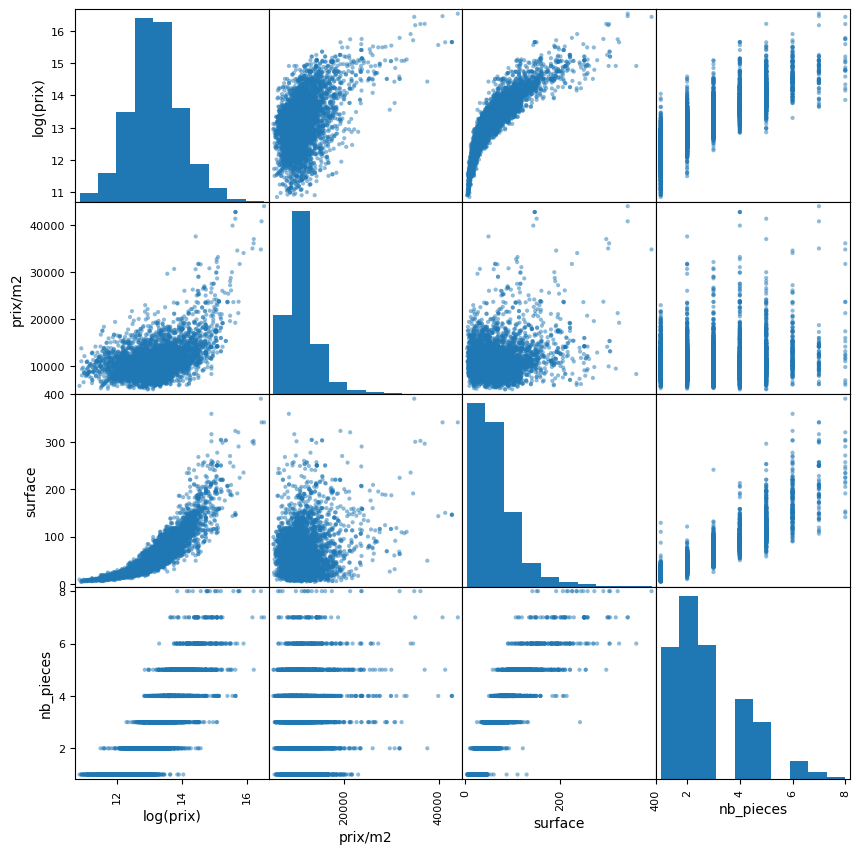

In [103]:
graph_correlation_heatmap(df,colonnes_numériques)
graph_bar_correlation_bracket(df)
graph_matrice_scatter(df, colonnes_numériques)

On observe que nos retraitements n'impactent pas les conclusions précédemment mentionnées. Les distributions restent similaires tout comme les corrélations.

Avant de commencer la modélisation, nous souhaitons exploiter les données de localisation que nous avons collectées pour créer une carte représentant les niveaux de prix des différentes zones. Comme mentionné précédemment, nous disposons désormais de la latitude et de la longitude pour chaque zone. On utilise la bibliothèque "folium" afin de créer notre carte et de visualiser nos zones sur la carte.

In [104]:
df=df.drop(columns=["surface_bracket","log(prix)"])

In [105]:
import folium

In [106]:
# Rapelle de la structure de "df"
df.head()

,id,type,nb_pieces,loc,surface,prix,loc1,loc2,loc3,loc1_x,loc1_y,loc2_x,loc2_y,loc3_x,loc3_y,prix/m2
0,hektor-PARISLUXURYHOMES-4007,Appartement,5,75002 Paris 2e (Palais Royal),106,2490000,Palais Royal,Quartier du Palais Royal,75001,48.863585,2.336204,48.864603,2.336049,48.864614,2.334396,23490.566038
1,ag754594-448898324,Studio,1,75001 Paris 1er (Saint-Germain - L'Auxerrois),27,365000,Saint-Germain,None,75006,48.856553,2.333331,NaN,NaN,48.850433,2.332951,13518.518519
2,keller-williams-1-34_1_53-180645,Appartement,2,75001 Paris 1er (Vendôme),67,1190000,Vendôme,Quartier Vendôme,75001,48.866900,2.328549,48.866900,2.328549,48.864614,2.334396,17761.19403
3,apimo-83606543,Maison,7,75006 Paris 6e (Saint-Germain - L'Auxerrois),341,15000000,Saint-Germain,None,75006,48.856553,2.333331,NaN,NaN,48.850433,2.332951,43988.269795
4,hektor-br-immobilier-4309,Appartement,2,75001 Paris 1er (Saint-Germain - L'Auxerrois),53,669000,Saint-Germain,None,75006,48.856553,2.333331,NaN,NaN,48.850433,2.332951,12622.641509


Nous commençons par créer une carte interactive centrée sur Paris. Nous sélectionnons les zones uniques en termes de coordonnées géographiques (latitude et longitude), puis nous ajoutons un marqueur pour chaque zone, en affichant son nom lorsque l'utilisateur clique sur le marqueur. Chaque marqueur est représenté par une icône bleue.

In [107]:
### CREATION DE LA CARTE ###

# Initialiser la carte centrée sur Paris
carte = folium.Map(location=[48.8566, 2.3522], zoom_start=12)
df_unique = df.drop_duplicates(subset=['loc1_x', 'loc1_y'])
# Ajouter des points sur la carte pour les adresses avec coordonnées
for idx, row in df_unique.iterrows():
    lat = row['loc1_x']
    lon = row['loc1_y']
    if pd.notna(lat) and pd.notna(lon):
        folium.Marker(
            location=[lat, lon],
            popup=f"{row['loc1']}",  # Texte affiché lorsqu'on clique sur le point
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(carte)


In [108]:
## Affichage de la carte
carte

Nous générons maintenant trois cartes interactives, chacune représentant une localisation à une échelle différente. Chaque carte couvre une zone plus large, et le nombre de points diminue à mesure que l'on passe de loc1 à loc3. Les points de chaque carte sont des cercles dont la couleur varie en fonction du prix moyen au m², allant du rouge clair au rouge foncé, et la taille des cercles est proportionnelle au nombre d'annonces dans chaque zone.
Les zones dans chacune des cartes sont regroupées par niveau de localisation (loc1, loc2, loc3) et pour chaque niveau on utilise les prix moyens au m² et la taille moyenne des annonces. Cette approche permet de visualiser les différences de prix et d'intensité des annonces à différentes échelles géographiques. 

NB : pour le 16ème arrondissement de Paris, il est administrativement divisé en deux : le 75016 et le 75116. Cependant, géopy nous renvoie les mêmes coordonnées pour les deux, ce qui explique qu'il y ait deux ronds dans "75016" sur la troisième carte.

In [109]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming 'df' is your DataFrame and it's already loaded

# Définir les niveaux de localisation et leurs colonnes de latitude et longitude correspondantes
location_levels = {
    'loc1': {'lat_col': 'loc1_x', 'lon_col': 'loc1_y'},
    'loc2': {'lat_col': 'loc2_x', 'lon_col': 'loc2_y'},
    'loc3': {'lat_col': 'loc3_x', 'lon_col': 'loc3_y'}
}

# Fonction pour mapper le prix/m² à une couleur (rouge clair à rouge foncé)
def prix_m2_to_color(prix_m2, min_price, max_price):
    # Normaliser le prix/m² entre 0 et 1
    norm = (prix_m2 - min_price) / (max_price - min_price) if max_price != min_price else 0.5
    # Utiliser une palette de couleurs 'Reds' pour du rouge clair à rouge foncé
    cmap = plt.cm.get_cmap('Reds')
    # Obtenir la couleur RGBA et la convertir en HEX
    color = mcolors.to_hex(cmap(norm))
    return color

# Fonction pour normaliser la taille des points en fonction du nombre d'annonces
def scale_radius(nombre_annonces, min_annonces, max_annonces, min_radius=5, max_radius=20):
    return min_radius + (max_radius - min_radius) * (nombre_annonces - min_annonces) / (max_annonces - min_annonces)

cartes = []

# Itérer sur chaque niveau de localisation
for loc, cols in location_levels.items():
    print(f"Traitement de {loc}...")

    # Regrouper par le niveau de localisation actuel
    résultat = df.groupby(loc, as_index=False).agg(
        moyenne_prix=('prix', 'mean'),      # Moyenne des prix
        moyenne_surface=('surface', 'mean'),  # Moyenne des surfaces
        nombre_annonces=('prix', 'size'),   # Nombre d'annonces (compte les lignes)
        latitude=(cols['lat_col'], 'first'),  # Latitude (première valeur)
        longitude=(cols['lon_col'], 'first')  # Longitude (première valeur)
    )

    # Calculer la moyenne des prix au m²
    résultat['prix_m2'] = résultat['moyenne_prix'] / résultat['moyenne_surface']
    résultat.dropna(inplace=True)

    # Déterminer les valeurs min et max pour la normalisation
    min_price_m2 = résultat['prix_m2'].min()
    max_price_m2 = résultat['prix_m2'].max()
    min_annonces = résultat['nombre_annonces'].min()
    max_annonces = résultat['nombre_annonces'].max()

    # Création de la carte
    carte = folium.Map(location=[48.8566, 2.3522], zoom_start=12)  # Centrée sur Paris ; ajuster si nécessaire

    # Ajouter les points sur la carte
    for _, row in résultat.iterrows():
        couleur = prix_m2_to_color(row['prix_m2'], min_price_m2, max_price_m2)  # Couleur basée sur le prix/m²
        radius = scale_radius(row['nombre_annonces'], min_annonces, max_annonces)  # Taille basée sur le nombre d'annonces
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=radius,  # Taille des points
            color='black',  # Contour noir
            fill=True,
            fill_color=couleur,  # Remplissage coloré
            fill_opacity=0.9,
            popup=(
                f"{row[loc]}<br>"
                f"Prix/m² : {row['prix_m2']:.2f} €<br>"
                f"Nombre d'annonces : {row['nombre_annonces']}"
            )
        ).add_to(carte)
    cartes.append(carte)

for i, carte in enumerate(cartes):
    print(f"Affichage de la carte {i+1} :")
    display(carte)

Traitement de loc1...
Traitement de loc2...
Traitement de loc3...
Affichage de la carte 1 :


/tmp/ipykernel_14803/3303092148.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')
/tmp/ipykernel_14803/3303092148.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')
/tmp/ipykernel_14803/3303092148.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Reds')


Affichage de la carte 2 :


Affichage de la carte 3 :


## IV. Modélisation ##

Dans une première partie, nous allons essayer de prédire le prix au m2 et non le prix car le prix est énormement dépendant de la surface et le modèle se concentrerait trop sur cette relation.

In [110]:
df_prix = df.copy() # pour la prochaine modélisation
# on dispose déjà de la colonne "prix/m2"
df=df.drop(columns=["prix"]) # on se sépare de la colonne du prix

df

,id,type,nb_pieces,loc,surface,loc1,loc2,loc3,loc1_x,loc1_y,loc2_x,loc2_y,loc3_x,loc3_y,prix/m2
0,hektor-PARISLUXURYHOMES-4007,Appartement,5,75002 Paris 2e (Palais Royal),106,Palais Royal,Quartier du Palais Royal,75001,48.863585,2.336204,48.864603,2.336049,48.864614,2.334396,23490.566038
1,ag754594-448898324,Studio,1,75001 Paris 1er (Saint-Germain - L'Auxerrois),27,Saint-Germain,None,75006,48.856553,2.333331,NaN,NaN,48.850433,2.332951,13518.518519
2,keller-williams-1-34_1_53-180645,Appartement,2,75001 Paris 1er (Vendôme),67,Vendôme,Quartier Vendôme,75001,48.866900,2.328549,48.866900,2.328549,48.864614,2.334396,17761.19403
3,apimo-83606543,Maison,7,75006 Paris 6e (Saint-Germain - L'Auxerrois),341,Saint-Germain,None,75006,48.856553,2.333331,NaN,NaN,48.850433,2.332951,43988.269795
4,hektor-br-immobilier-4309,Appartement,2,75001 Paris 1er (Saint-Germain - L'Auxerrois),53,Saint-Germain,None,75006,48.856553,2.333331,NaN,NaN,48.850433,2.332951,12622.641509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,hektor-arcales1-1270,Appartement,4,75020 Paris 20e (Plaine - Lagny),76,Plaine,Quartier de Charonne,75020,48.850152,2.402190,48.855145,2.397638,48.865042,2.398929,7776.315789
5535,ag755800-420870928,Appartement,2,75020 Paris 20e (Père Lachaise - Réunion),10,Père Lachaise,Quartier du Père-Lachaise,75020,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929,9900.0
5536,apimo-83966258,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),22,Père Lachaise,Quartier du Père-Lachaise,75020,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929,10863.636364
5537,ag755800-412953689,Appartement,1,75020 Paris 20e (Père Lachaise - Réunion),35,Père Lachaise,Quartier du Père-Lachaise,75020,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929,6845.714286


In [111]:
df['loc2_x'] = df['loc2_x'].fillna(df['loc1_x'])
df['loc2_y'] = df['loc2_y'].fillna(df['loc1_y'])
df['loc2']= df['loc2'].fillna(df['loc1'])

In [112]:
# Garder ce qui nous intéresse
# On suprimme l'id car inutile pour estimer le prix
df = df.drop(columns=['id'])
# On suprimme supprime les localisations  dans un premier temps car on suppose l'information inclus dans les coordonnées géographiques
df = df.drop(columns=["loc","loc1","loc2","loc3"])
df

,type,nb_pieces,surface,loc1_x,loc1_y,loc2_x,loc2_y,loc3_x,loc3_y,prix/m2
0,Appartement,5,106,48.863585,2.336204,48.864603,2.336049,48.864614,2.334396,23490.566038
1,Studio,1,27,48.856553,2.333331,48.856553,2.333331,48.850433,2.332951,13518.518519
2,Appartement,2,67,48.866900,2.328549,48.866900,2.328549,48.864614,2.334396,17761.19403
3,Maison,7,341,48.856553,2.333331,48.856553,2.333331,48.850433,2.332951,43988.269795
4,Appartement,2,53,48.856553,2.333331,48.856553,2.333331,48.850433,2.332951,12622.641509
...,...,...,...,...,...,...,...,...,...,...
5534,Appartement,4,76,48.850152,2.402190,48.855145,2.397638,48.865042,2.398929,7776.315789
5535,Appartement,2,10,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929,9900.0
5536,Appartement,1,22,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929,10863.636364
5537,Appartement,1,35,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929,6845.714286


In [113]:
#Encod the sting variables
# One hot encoding seems better for variables with a few values taken and now cardinality

df_encoded = pd.get_dummies(df, columns=['type'], prefix='type',dtype=float)
df_encoded

,nb_pieces,surface,loc1_x,loc1_y,loc2_x,loc2_y,loc3_x,loc3_y,prix/m2,type_Appartement,type_Duplex,type_Maison,type_Studio
0,5,106,48.863585,2.336204,48.864603,2.336049,48.864614,2.334396,23490.566038,1.0,0.0,0.0,0.0
1,1,27,48.856553,2.333331,48.856553,2.333331,48.850433,2.332951,13518.518519,0.0,0.0,0.0,1.0
2,2,67,48.866900,2.328549,48.866900,2.328549,48.864614,2.334396,17761.19403,1.0,0.0,0.0,0.0
3,7,341,48.856553,2.333331,48.856553,2.333331,48.850433,2.332951,43988.269795,0.0,0.0,1.0,0.0
4,2,53,48.856553,2.333331,48.856553,2.333331,48.850433,2.332951,12622.641509,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,4,76,48.850152,2.402190,48.855145,2.397638,48.865042,2.398929,7776.315789,1.0,0.0,0.0,0.0
5535,2,10,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929,9900.0,1.0,0.0,0.0,0.0
5536,1,22,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929,10863.636364,1.0,0.0,0.0,0.0
5537,1,35,48.861130,2.394009,48.863752,2.395302,48.865042,2.398929,6845.714286,1.0,0.0,0.0,0.0


In [114]:
# Let's normalize the variable so to reduce the impact of the scale of the input features of the model (SVM for now)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#Binary variables don't need to be normalized
numerical_cols = ["nb_pieces", "surface", 'prix/m2', "loc1_x", "loc1_y", "loc2_x", "loc2_y", "loc3_x", "loc3_y"]

df_standardized = df_encoded.copy()
df_standardized[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])
df_standardized

,nb_pieces,surface,loc1_x,loc1_y,loc2_x,loc2_y,loc3_x,loc3_y,prix/m2,type_Appartement,type_Duplex,type_Maison,type_Studio
0,1.551494,0.962824,0.078959,-0.138066,0.103113,-0.193201,0.023419,-0.155048,3.427686,1.0,0.0,0.0,0.0
1,-1.190989,-0.798942,-0.241553,-0.208768,-0.248924,-0.254464,-0.655571,-0.191955,0.667696,0.0,0.0,0.0,1.0
2,-0.505368,0.093091,0.230066,-0.326449,0.203538,-0.362255,0.023419,-0.155048,1.841953,1.0,0.0,0.0,0.0
3,2.922735,6.203521,-0.241553,-0.208768,-0.248924,-0.254464,-0.655571,-0.191955,9.100892,0.0,0.0,1.0,0.0
4,-0.505368,-0.219120,-0.241553,-0.208768,-0.248924,-0.254464,-0.655571,-0.191955,0.419741,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,0.865873,0.293799,-0.533296,1.485722,-0.310467,1.194999,0.043892,1.492871,-0.921590,1.0,0.0,0.0,0.0
5535,-0.505368,-1.178056,-0.032937,1.284391,0.065891,1.142362,0.043892,1.492871,-0.333812,1.0,0.0,0.0,0.0
5536,-1.190989,-0.910446,-0.032937,1.284391,0.065891,1.142362,0.043892,1.492871,-0.067103,1.0,0.0,0.0,0.0
5537,-1.190989,-0.620535,-0.032937,1.284391,0.065891,1.142362,0.043892,1.492871,-1.179155,1.0,0.0,0.0,0.0


In [115]:
from sklearn.model_selection import cross_val_score, KFold

# Séparation des inputs et outputs
X = df_standardized.drop(columns=['prix/m2'])
y = df_standardized['prix/m2']
# Afficher les lignes de X qui contiennent des NaN
nan_rows_X = X[X.isna().any(axis=1)]
print("Lignes avec NaN dans X:")
print(nan_rows_X)
# Afficher les indices où y est NaN
nan_indices_y = y[y.isna()]
print("Indices avec NaN dans y:")
print(nan_indices_y)

# Validation croisée avec 10 folds pour réduire l'aléatoire du splitting
kf = KFold(n_splits=10, shuffle=True)

#Au cas ou, nous créons une partition
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Lignes avec NaN dans X:
      nb_pieces   surface    loc1_x    loc1_y    loc2_x    loc2_y  loc3_x  \
312   -1.190989 -1.200357 -0.829950  0.255102 -0.874649  0.270938     NaN   
313    1.551494  1.230434 -0.893771  0.051125 -0.874649 -0.016414     NaN   
314   -1.190989 -0.732040 -0.829950  0.255102 -0.874649  0.270938     NaN   
315    0.180252  0.628311 -0.829950  0.255102 -0.874649  0.270938     NaN   
316    1.551494  0.784417 -0.893771  0.051125 -0.874649 -0.016414     NaN   
...         ...       ...       ...       ...       ...       ...     ...   
4559  -1.190989 -1.178056 -0.893771  0.051125 -0.874649 -0.016414     NaN   
4560  -1.190989 -0.732040 -0.893771  0.051125 -0.874649 -0.016414     NaN   
4561  -0.505368 -0.821243 -0.581376  0.086021 -0.574944  0.015550     NaN   
4562   1.551494  1.252735 -0.829950  0.255102 -0.874649  0.270938     NaN   
4564  -1.190989 -0.620535 -0.829950  0.255102 -0.874649  0.270938     NaN   

      loc3_y  type_Appartement  type_Duplex  type_M

Testons différents models :

In [116]:
#Imports for metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Création des métrics
from sklearn.metrics import make_scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

In [117]:
#Linear regression
from sklearn.linear_model import LinearRegression
modelLR = LinearRegression()

# Calcul des scores
mae_scores = cross_val_score(modelLR, X, y, scoring=mae_scorer, cv=kf)
mse_scores = cross_val_score(modelLR, X, y, scoring=mse_scorer, cv=kf)
r2_scores = cross_val_score(modelLR, X, y, scoring=r2_scorer, cv=kf)


# Résultats moyens
print("MAE moyen :", -np.mean(mae_scores)) #Use of - du to greater_is_better=False
print("MSE moyen :", -np.mean(mse_scores)) #Use of - du to greater_is_better=False
print("R² moyen :", np.mean(r2_scores))
print("Écart-type R² :", np.std(r2_scores))

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_base.py", line 601, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1107, in check_array
    _assert_all_finite(
  File "/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

modelRFR = RandomForestRegressor()

# Calcul des scores
mae_scores = cross_val_score(modelRFR, X, y, scoring=mae_scorer, cv=kf)
mse_scores = cross_val_score(modelRFR, X, y, scoring=mse_scorer, cv=kf)
r2_scores = cross_val_score(modelRFR, X, y, scoring=r2_scorer, cv=kf)

# Résultats moyens
print("MAE moyen :", -np.mean(mae_scores)) #Use of - du to greater_is_better=False
print("MSE moyen :", -np.mean(mse_scores)) #Use of - du to greater_is_better=False
print("R² moyen :", np.mean(r2_scores))
print("Écart-type R² :", np.std(r2_scores))

MAE moyen : 0.42514781412328817
MSE moyen : 0.47744782327425506
R² moyen : 0.5324982405485207
Écart-type R² : 0.04535360377928956


In [ ]:
#SVM
from sklearn.svm import SVR

modelSVR = SVR()

# Calcul des scores
mae_scores = cross_val_score(modelSVR, X, y, scoring=mae_scorer, cv=kf)
mse_scores = cross_val_score(modelSVR, X, y, scoring=mse_scorer, cv=kf)
r2_scores = cross_val_score(modelSVR, X, y, scoring=r2_scorer, cv=kf)

# Résultats moyens
print("MAE moyen :", -np.mean(mae_scores)) #Use of - du to greater_is_better=False
print("MSE moyen :", -np.mean(mse_scores)) #Use of - du to greater_is_better=False
print("R² moyen :", np.mean(r2_scores))
print("Écart-type R² :", np.std(r2_scores))

MAE moyen : 0.47980701223826483
MSE moyen : 0.6600168787407381
R² moyen : 0.3422447759208141
Écart-type R² : 0.045378836627352495


In [ ]:
!pip install xgboost

In [ ]:
#Puisque l'arbre semble le plus prométeur, testons une verion boostée
from xgboost import XGBRegressor

modelXGB = XGBRegressor(
    n_estimators=100,      # Nombre d'arbres
    learning_rate=0.1,     # Taux d'apprentissage
    max_depth=5,           # Profondeur maximale des arbres
)

# Calcul des scores
mae_scores = cross_val_score(modelXGB, X, y, scoring=mae_scorer, cv=kf)
mse_scores = cross_val_score(modelXGB, X, y, scoring=mse_scorer, cv=kf)
r2_scores = cross_val_score(modelXGB, X, y, scoring=r2_scorer, cv=kf)

# Résultats moyens
print("MAE moyen :", -np.mean(mae_scores)) #Use of - du to greater_is_better=False
print("MSE moyen :", -np.mean(mse_scores)) #Use of - du to greater_is_better=False
print("R² moyen :", np.mean(r2_scores))
print("Écart-type R² :", np.std(r2_scores))

MAE moyen : 0.43993987889905367
MSE moyen : 0.46872770528198
R² moyen : 0.527849437715852
Écart-type R² : 0.025578866843289305


In [ ]:
#Ce n'est pas mieux que l'arbre classique donc essayons d'optimiser les paramêtres
from sklearn.model_selection import RandomizedSearchCV

# Définir une grille de paramêtres
param_dist = {
    'n_estimators': np.linspace(50, 500, 10).astype(int),
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': [6,7,8,9,10,11,12],
}

#Model de recherche de paramêtres
grid_search  = RandomizedSearchCV(
    estimator=modelXGB,
    param_distributions=param_dist,
    n_iter=50,                          # Nombre d'itérations
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

grid_search .fit(X, y)

best_params = grid_search .best_params_
final_model = XGBRegressor(**best_params)

# Calcul des scores
mae_scores = cross_val_score(final_model, X, y, scoring=mae_scorer, cv=kf)
mse_scores = cross_val_score(final_model, X, y, scoring=mse_scorer, cv=kf)
r2_scores = cross_val_score(final_model, X, y, scoring=r2_scorer, cv=kf)

# Résultats moyens
print("MAE moyen :", -np.mean(mae_scores)) #Use of - du to greater_is_better=False
print("MSE moyen :", -np.mean(mse_scores)) #Use of - du to greater_is_better=False
print("R² moyen :", np.mean(r2_scores))
print("Écart-type R² :", np.std(r2_scores))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
MAE moyen : 0.42782029963630386
MSE moyen : 0.4497253317805597
R² moyen : 0.533559372242127
Écart-type R² : 0.0626339348858112


In [ ]:
best_params

{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.07333333333333333}

Etrangement, le XGboost n'est pas meilleur que l'arbre classique.
Je n'ai surement pas réussi à trouver le meilleur paramêtre durant mes divers essais.
Les résultats sont plutôt mauvais puisque l'on travail sur des valeurs normalisées, 0.48594887909663703 de MAE est élévé

### Visualisation

In [ ]:
best_model=modelRFR

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
best_model.fit(X_train,y_train)
y_predict=best_model.predict(X_test)

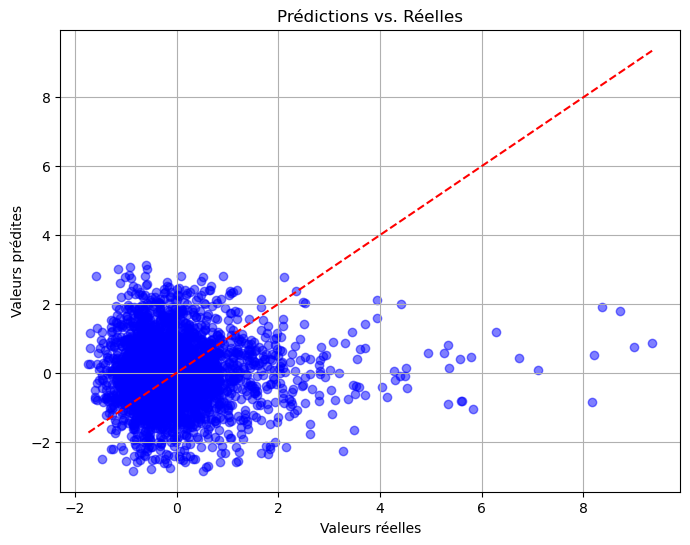

In [ ]:
import matplotlib.pyplot as plt

# Graphique de Prédictions vs. Réelles (scatter plot)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ligne y=x
plt.title("Prédictions vs. Réelles")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.grid(True)
plt.show()

C'est assez catastrophique. Les predictions ne sont pas alignées avec les valeurs réelles. De plus les valeurs extrèmes sont toujours mals prédites. C'est tout comme si notre prédiction était du bruit.

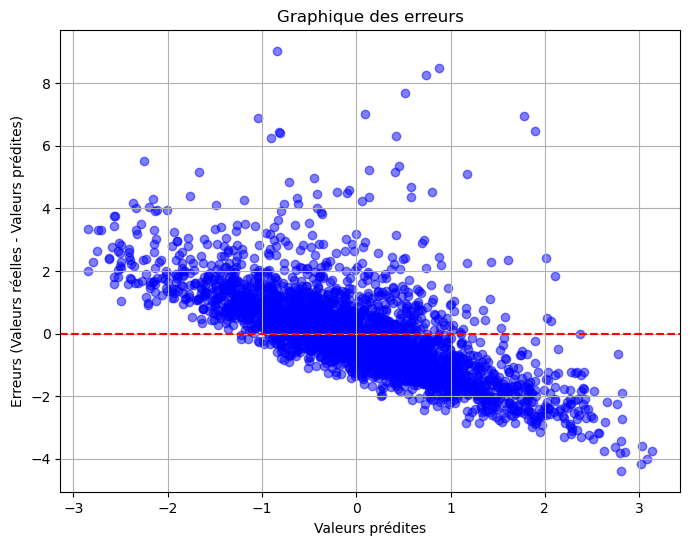

In [ ]:
# Calcul des erreurs
errors = y_test - y_pred

# Graphique des erreurs
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, errors, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Ligne des erreurs nulles
plt.title("Graphique des erreurs")
plt.xlabel("Valeurs prédites")
plt.ylabel("Erreurs (Valeurs réelles - Valeurs prédites)")
plt.grid(True)
plt.show()

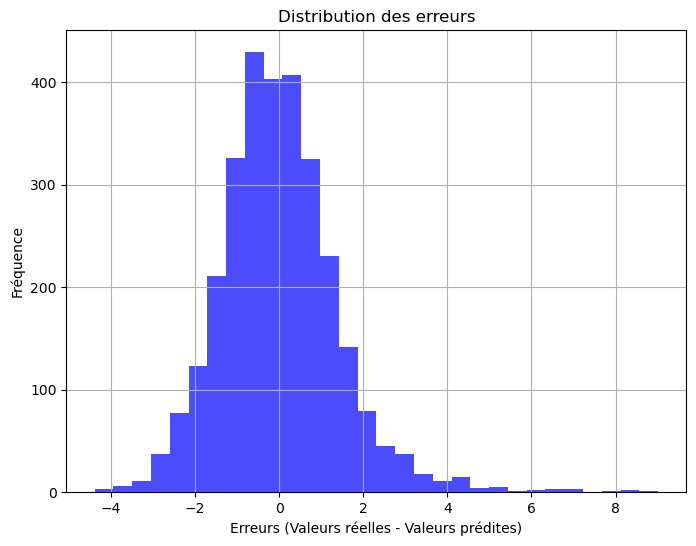

In [ ]:
# Histogramme des erreurs
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, color='blue', alpha=0.7)
plt.title("Distribution des erreurs")
plt.xlabel("Erreurs (Valeurs réelles - Valeurs prédites)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

L'erreur reste gaussienne et est centrée donc il n'y a pas de biais.

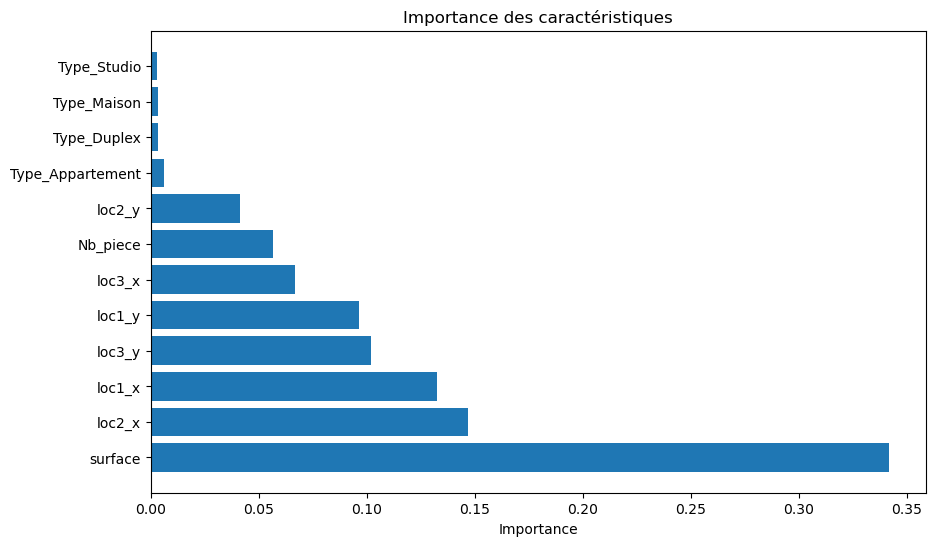

In [ ]:
# Importance des caractéristiques pour Random Forest
importances = modelRFR.feature_importances_

# Trier les importances
indices = np.argsort(importances)[::-1]

# Visualisation
plt.figure(figsize=(10, 6))
plt.title("Importance des caractéristiques")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.xlabel("Importance")
plt.show()

La surface reste la caractéristique prépondérante malgrès le fait que l'on essaye de prédire le prix/m²\
Cependant elle accapare une moins grande part de la prédiction que si l'on essaye de prédire jutste le prix

#### Prédiction du log(prix) via le modèle Random Forest ####

Dans le cas de la prédiction du log(prix), le meilleur modèle testé est le Random Forest comme suit :

In [ ]:

df_prix["prix"]=np.log(df_prix["prix"]) # calcul du log du prix
df_prix['loc2_x'] = df_prix['loc2_x'].fillna(df_prix['loc1_x'])
df_prix['loc2_y'] = df_prix['loc2_y'].fillna(df_prix['loc1_y'])
df_prix['loc2']= df_prix['loc2'].fillna(df_prix['loc1'])

df_prix=df_prix.drop(columns=['prix/m2'])

df_prix["prix"]=np.log(df_prix["prix"])

df_prix = df_prix.drop(columns=['id'])
df_prix = df_prix.drop(columns=["loc","loc1","loc2","loc3"])

df_encoded_prix = pd.get_dummies(df_prix, columns=['type'], prefix='type',dtype=float)


# Separation of inputs and outputs
X_prix = df_encoded_prix.drop(columns=["prix"])
y_prix = df_encoded_prix["prix"]

# Standardize the input features
scaler_prix_X = StandardScaler()
numerical_cols = ["nb_pieces", "surface", "loc1_x", "loc1_y", "loc2_x", "loc2_y", "loc3_x", "loc3_y"]
X_prix[numerical_cols] = scaler_prix_X.fit_transform(X_prix[numerical_cols])

scaler_prix_y = StandardScaler()
y_prix=scaler_prix_y.fit_transform(y_prix.values.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X_prix, y_prix, test_size=0.3)

best_model=modelRFR

In [ ]:
# Calcul des scores
mae_scores = cross_val_score(best_model, X_prix, y_prix, scoring=mae_scorer, cv=kf)
mse_scores = cross_val_score(best_model,  X_prix, y_prix, scoring=mse_scorer, cv=kf)
r2_scores = cross_val_score(best_model,  X_prix, y_prix, scoring=r2_scorer, cv=kf)

# Résultats moyens
print("MAE moyen :", -np.mean(mae_scores)) #Use of - du to greater_is_better=False
print("MSE moyen :", -np.mean(mse_scores)) #Use of - du to greater_is_better=False
print("R² moyen :", np.mean(r2_scores))
print("Écart-type R² :", np.std(r2_scores))

MAE moyen : 0.1632025275284671
MSE moyen : 0.05342653449314191
R² moyen : 0.9467812664824239
Écart-type R² : 0.004329530000053218


In [ ]:
best_model.fit(X_train,y_train)
y_pred=best_model.predict(X_test)

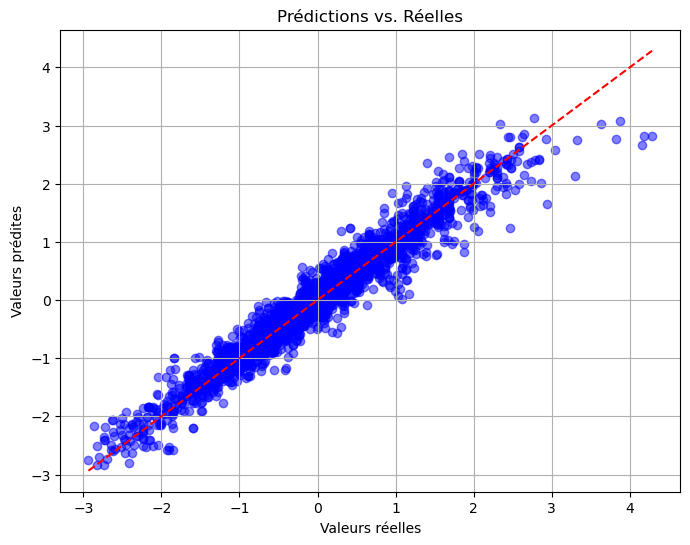

In [ ]:
import matplotlib.pyplot as plt

# Graphique de Prédictions vs. Réelles (scatter plot)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ligne y=x
plt.title("Prédictions vs. Réelles")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.grid(True)
plt.show()

In [ ]:
# Reverse the scaling for the test target values
y_test_reel = scaler_prix_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Reverse the scaling for the predicted values
y_pred_reel = scaler_prix_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()

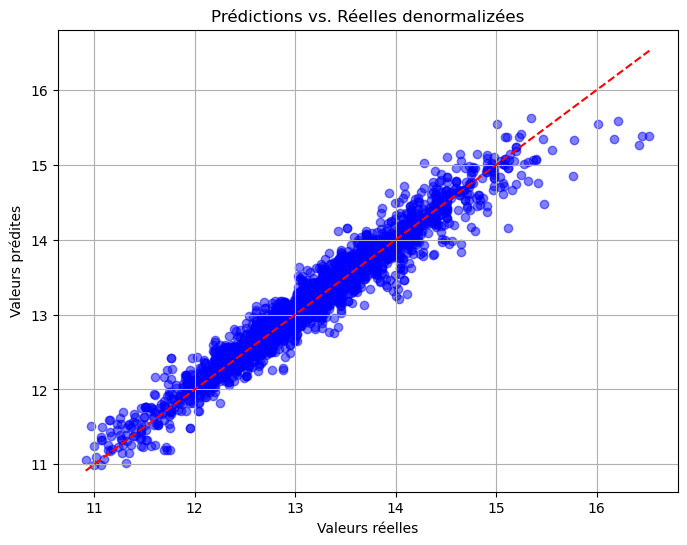

In [ ]:
# Graphique de Prédictions vs. Réelles (scatter plot)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reel, y_pred_reel, color='blue', alpha=0.5)
plt.plot([min(y_test_reel), max(y_test_reel)], [min(y_test_reel), max(y_test_reel)], color='red', linestyle='--')  # Ligne y=x
plt.title("Prédictions vs. Réelles denormalisées")
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.grid(True)
plt.show()

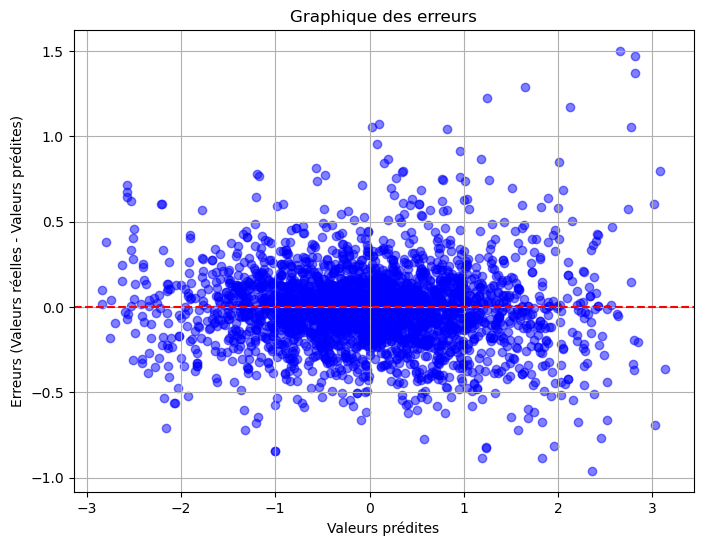

In [ ]:
# Calcul des erreurs
errors = y_test - y_pred

# Graphique des erreurs
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, errors, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Ligne des erreurs nulles
plt.title("Graphique des erreurs")
plt.xlabel("Valeurs prédites")
plt.ylabel("Erreurs (Valeurs réelles - Valeurs prédites)")
plt.grid(True)
plt.show()

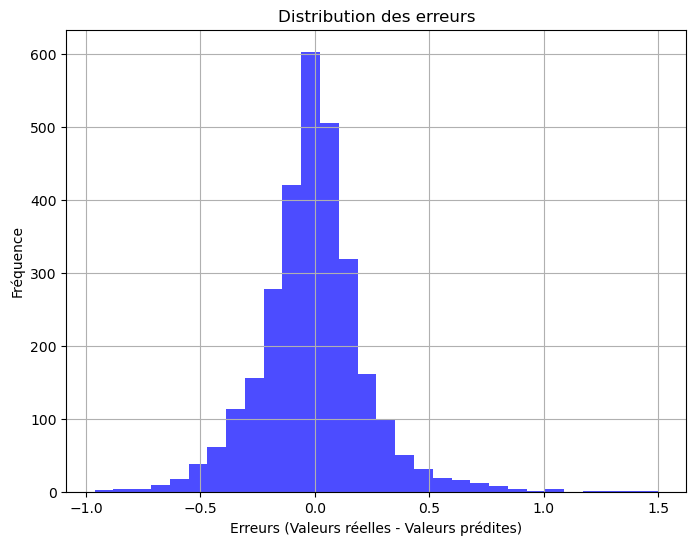

In [ ]:
# Histogramme des erreurs
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, color='blue', alpha=0.7)
plt.title("Distribution des erreurs")
plt.xlabel("Erreurs (Valeurs réelles - Valeurs prédites)")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

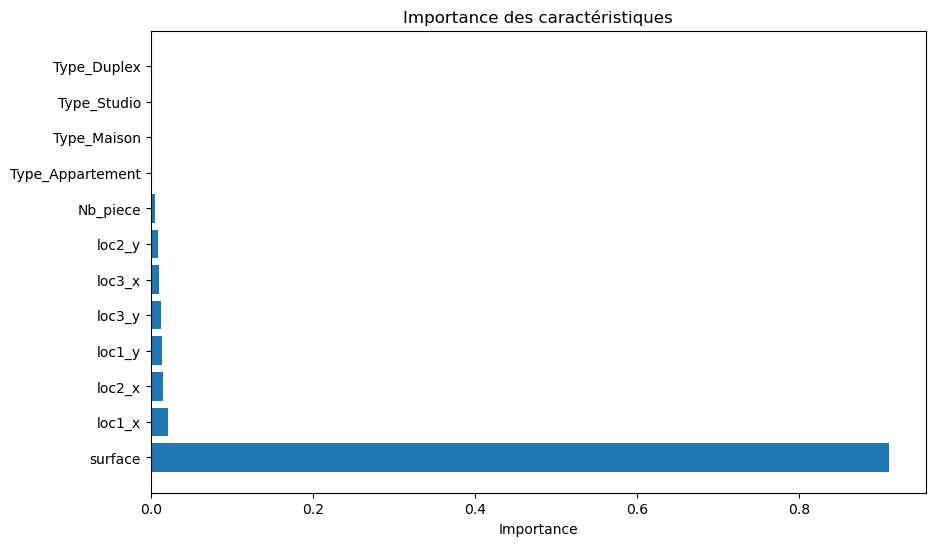

In [ ]:
# Importance des caractéristiques pour Random Forest
importances = modelRFR.feature_importances_

# Trier les importances
indices = np.argsort(importances)[::-1]

# Visualisation
plt.figure(figsize=(10, 6))
plt.title("Importance des caractéristiques")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.xlabel("Importance")
plt.show()

## Conclusion ##